# Importation des librairies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yaml
import os
import tempfile
import warnings

from imblearn.under_sampling import RandomUnderSampler

from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split


import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau

from sklearn.metrics import classification_report, accuracy_score


#warnings.filterwarnings("ignore")

# Lecture du fichier data_cleaned_final_sans_dummies.csv

In [2]:
file = open('../../../conf/global_conf.yml', 'r') 
conf = yaml.safe_load(file)
df = pd.read_csv(conf['local_data_path'] + "data_cleaned_final_sans_dummies.csv",index_col=0,low_memory=False)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 447136 entries, 0 to 494017
Data columns (total 41 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   jour            447136 non-null  int64  
 1   mois            447136 non-null  int64  
 2   an              447136 non-null  int64  
 3   lum             447136 non-null  float64
 4   dep             447136 non-null  object 
 5   agg             447136 non-null  int64  
 6   int             447136 non-null  float64
 7   atm             447136 non-null  float64
 8   col             447136 non-null  float64
 9   lat             447136 non-null  float64
 10  long            447136 non-null  float64
 11  catr            447136 non-null  int64  
 12  circ            447136 non-null  float64
 13  prof            447136 non-null  float64
 14  plan            447136 non-null  float64
 15  surf            447136 non-null  float64
 16  infra           447136 non-null  float64
 17  situ           

In [4]:
cat = ['lum', 'agg', 'int', 'atm', 'col', 'catr', 'circ',
       'prof', 'plan', 'surf', 'infra', 'situ', 'grav', 'sexe', 'catv', 'obs',
       'obsm', 'manv', 'motor', 'weekend', 'place_rec',
       'eq_ceinture', 'eq_casque', 'eq_siege', 'eq_gilet', 'eq_airbag',
       'eq_gants', 'eq_indetermine', 'eq_autre', 'jour_chome', 'prox_pt_choc']
df[cat] = df[cat].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 447136 entries, 0 to 494017
Data columns (total 41 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   jour            447136 non-null  int64  
 1   mois            447136 non-null  int64  
 2   an              447136 non-null  int64  
 3   lum             447136 non-null  int64  
 4   dep             447136 non-null  object 
 5   agg             447136 non-null  int64  
 6   int             447136 non-null  int64  
 7   atm             447136 non-null  int64  
 8   col             447136 non-null  int64  
 9   lat             447136 non-null  float64
 10  long            447136 non-null  float64
 11  catr            447136 non-null  int64  
 12  circ            447136 non-null  int64  
 13  prof            447136 non-null  int64  
 14  plan            447136 non-null  int64  
 15  surf            447136 non-null  int64  
 16  infra           447136 non-null  int64  
 17  situ           

Suppression des variables inutiles

In [5]:
df = df.drop(['an','jour', 'grav_rec', 'date', 'dep'], axis=1)

Renumérotation de la variable cible

In [6]:
df['grav'] = df['grav'].replace([1, 2, 3, 4], [0, 1, 2, 3])

# Séparation en train et test

Séparation des données de la cible

In [7]:
X = df.drop('grav', axis = 1)
y = df['grav']

y.value_counts(normalize = True)

grav
0    0.412733
3    0.403430
2    0.156550
1    0.027287
Name: proportion, dtype: float64

Séparation en train et test en gardant la même porportion de chaque modalité de la cible dans les jeux d'entraînement et de test.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42, stratify = y)

print(y_train.value_counts(normalize = True))
print(y_test.value_counts(normalize = True))

grav
0    0.412733
3    0.403430
2    0.156549
1    0.027288
Name: proportion, dtype: float64
grav
0    0.412733
3    0.403430
2    0.156552
1    0.027285
Name: proportion, dtype: float64


In [9]:
X_train.shape

(335352, 35)

Normalisation des données

In [10]:
# Normalisation de 'heure' et 'mois' pour X_train et X_test
X_train['heure_sin'] = np.sin(X_train['heure']*(2.*np.pi/24))
X_train['heure_cos'] = np.cos(X_train['heure']*(2.*np.pi/24))

X_train['mois_sin'] = np.sin(X_train['mois']*(2.*np.pi/24))
X_train['mois_cos'] = np.cos(X_train['mois']*(2.*np.pi/24))

X_test['heure_sin'] = np.sin(X_test['heure']*(2.*np.pi/24))
X_test['heure_cos'] = np.cos(X_test['heure']*(2.*np.pi/24))

X_test['mois_sin'] = np.sin(X_test['mois']*(2.*np.pi/24))
X_test['mois_cos'] = np.cos(X_test['mois']*(2.*np.pi/24))

X_train = X_train.drop(['heure', 'mois'], axis = 1)
X_test = X_test.drop(['heure', 'mois'], axis = 1)

In [11]:
# Normalisation de 'lat' et 'long'
scaler1 = RobustScaler()
X_train[['lat', 'long']] = scaler1.fit_transform(X_train[['lat', 'long']])
X_test[['lat', 'long']] = scaler1.transform(X_test[['lat', 'long']])

In [12]:
# Normalisation 'age_usager'
scaler1 = StandardScaler()
X_train[['age_usager']] = scaler1.fit_transform(X_train[['age_usager']])
X_test[['age_usager']] = scaler1.transform(X_test[['age_usager']])

# Undersampling sur le jeu de données

In [13]:
rUs = RandomUnderSampler()
X_train_ru, y_train_ru = rUs.fit_resample(X_train, y_train)
print('Classes échantillon oversampled :', dict(pd.Series(y_train_ru).value_counts()))

Classes échantillon oversampled : {0: 9151, 1: 9151, 2: 9151, 3: 9151}


# Construction et entraînement du modèle

### Calbacks

In [14]:
reduce_learning_rate = ReduceLROnPlateau(monitor = 'val_loss',
                                        min_delta = 0.01,
                                        patience = 5,
                                        factor = 0.5, 
                                        cooldown = 2,
                                        verbose = 1)

### Modèle 1 : Modèle de base

In [15]:
model1 = Sequential()
model1.add( Dense(units = 70, activation = 'relu', input_shape = (X_train.shape[1],)))
model1.add(Dense(units = 140, activation = 'relu'))
model1.add(Dropout(rate = 0.2))
model1.add( Dense(units = 70, activation = 'relu'))
model1.add(Dense(units = 35, activation = 'relu'))
model1.add(Dropout(rate = 0.2))
model1.add(Dense(units = 14, activation = 'relu'))
model1.add(Dense(units = 4, activation = 'softmax'))

model1.summary()

/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 70)             │         2,660 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 140)            │         9,940 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 140)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 70)             │         9,870 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 35)             │         2,485 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 35)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 14)             │           504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │            60 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,519 (99.68 KB)

 Trainable params: 25,519 (99.68 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
model1.compile(loss = "sparse_categorical_crossentropy",
               optimizer = "adam",
               metrics = ['sparse_categorical_accuracy'])

In [17]:
history1 = model1.fit(X_train_ru, y_train_ru, epochs = 100, batch_size = 512, validation_split = 0.1, callbacks = [reduce_learning_rate])

Epoch 1/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.3681 - sparse_categorical_accuracy: 0.3124 - val_loss: 1.6373 - val_sparse_categorical_accuracy: 0.0183 - learning_rate: 0.0010
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1591 - sparse_categorical_accuracy: 0.4758 - val_loss: 1.6019 - val_sparse_categorical_accuracy: 0.0650 - learning_rate: 0.0010
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0855 - sparse_categorical_accuracy: 0.5144 - val_loss: 1.5605 - val_sparse_categorical_accuracy: 0.1106 - learning_rate: 0.0010
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0583 - sparse_categorical_accuracy: 0.5295 - val_loss: 1.5635 - val_sparse_categorical_accuracy: 0.1538 - learning_rate: 0.0010
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0522 - sparse_categorical_accuracy: 0.5319 - val_loss: 1.5485 - val_sparse_categorical_accuracy: 0.0535 - learning_rate: 0.0010
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - lo

In [18]:
plt.figure(figsize =(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history1.history['loss'], label = 'train')
plt.plot(history1.history['val_loss'], label = 'valid')
plt.xlabel("Epochs")
plt.ylabel('Loss')
plt.legend()
plt.title("Loss per epoch")

plt.subplot(1, 2, 2)
plt.plot(history1.history['sparse_categorical_accuracy'], label = 'train')
plt.plot(history1.history['val_sparse_categorical_accuracy'], label = 'valid')
plt.xlabel("Epochs")
plt.ylabel('Accuracy')
plt.legend()
plt.title("Accuracy per epoch")

plt.show()

In [20]:
test_pred = model1.predict(X_test)
test_pred_class = test_pred.argmax(axis=1)

# Affichage des résultats
print(classification_report(y_test, test_pred_class), '\n\n')

display(pd.crosstab(y_test, test_pred_class, rownames = ['Classe réelle'], colnames = ['Classe prédite']))

print('\n\n Accuracy : ', np.round(accuracy_score(y_test, test_pred_class), 2)*100)

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 1s 230us/step
              precision    recall  f1-score   support

           0       0.68      0.83      0.74     46137
           1       0.12      0.66      0.21      3050
           2       0.30      0.46      0.36     17500
           3       0.75      0.21      0.33     45097

    accuracy                           0.52    111784
   macro avg       0.46      0.54      0.41    111784
weighted avg       0.63      0.52      0.50    111784
 




Classe prédite      0     1      2     3
Classe réelle                           
0               38075  2870   3482  1710
1                 227  2002    725    96
2                2043  6036   7973  1448
3               15870  5495  14049  9683



 Accuracy :  52.0


### Modèle 2 : recherche du meilleur loss

Epoch 1/100


/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 697.1898 - sparse_categorical_accuracy: 0.3064 - val_loss: 847.8401 - val_sparse_categorical_accuracy: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 595.9224 - sparse_categorical_accuracy: 0.4794 - val_loss: 775.1445 - val_sparse_categorical_accuracy: 0.0489 - learning_rate: 0.0010
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 560.1506 - sparse_categorical_accuracy: 0.5167 - val_loss: 695.1487 - val_sparse_categorical_accuracy: 0.1338 - learning_rate: 0.0010
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 547.0698 - sparse_categorical_accuracy: 0.5298 - val_loss: 693.7418 - val_sparse_categorical_accuracy: 0.1456 - learning_rate: 0.0010
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 536.7296 - sparse_categorical_accuracy: 0.5368 - val_loss: 698.8557 - val_sparse_categorical_accuracy: 0.1450 - learning_rate: 0.0010
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2

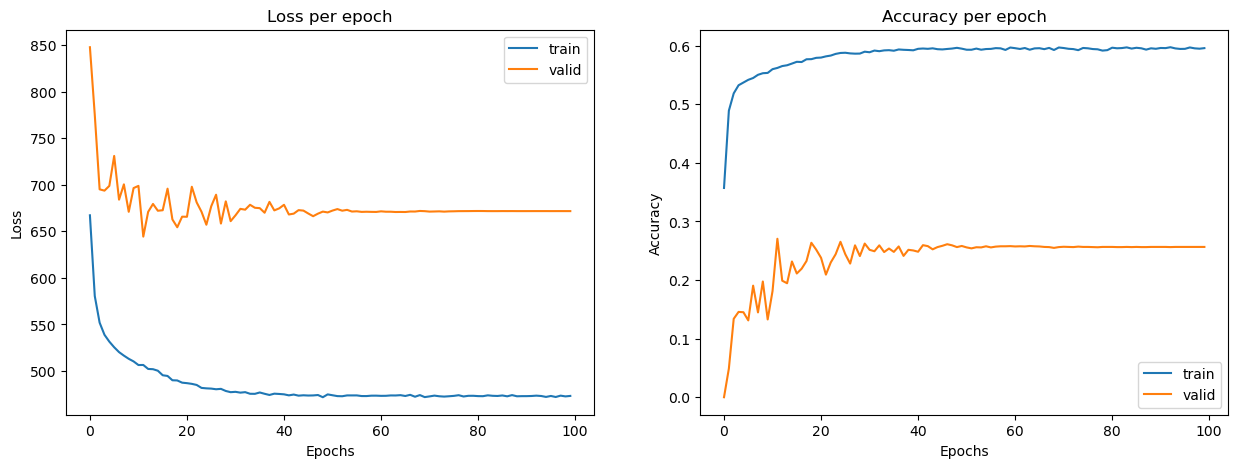

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 1s 254us/step
              precision    recall  f1-score   support

           0       0.69      0.81      0.75     46137
           1       0.12      0.64      0.21      3050
           2       0.30      0.46      0.36     17500
           3       0.73      0.25      0.37     45097

    accuracy                           0.52    111784
   macro avg       0.46      0.54      0.42    111784
weighted avg       0.63      0.52      0.52    111784
 




Classe prédite      0     1      2      3
Classe réelle                            
0               37193  2836   3655   2453
1                 222  1947    794     87
2                1835  5875   8026   1764
3               14415  5240  14087  11355



 Accuracy :  52.0
Epoch 1/100


/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.3309 - sparse_categorical_accuracy: 0.3560 - val_loss: 1.7276 - val_sparse_categorical_accuracy: 0.0931 - learning_rate: 0.0010
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1396 - sparse_categorical_accuracy: 0.4908 - val_loss: 1.6151 - val_sparse_categorical_accuracy: 0.0975 - learning_rate: 0.0010
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0909 - sparse_categorical_accuracy: 0.5107 - val_loss: 1.5680 - val_sparse_categorical_accuracy: 0.0702 - learning_rate: 0.0010
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0667 - sparse_categorical_accuracy: 0.5219 - val_loss: 1.4490 - val_sparse_categorical_accuracy: 0.1543 - learning_rate: 0.0010
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0531 - sparse_categorical_accuracy: 0.5332 - val_loss: 1.4965 - val_sparse_categorical_accuracy: 0.1120 - learning_rate: 0.0010
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0413 -

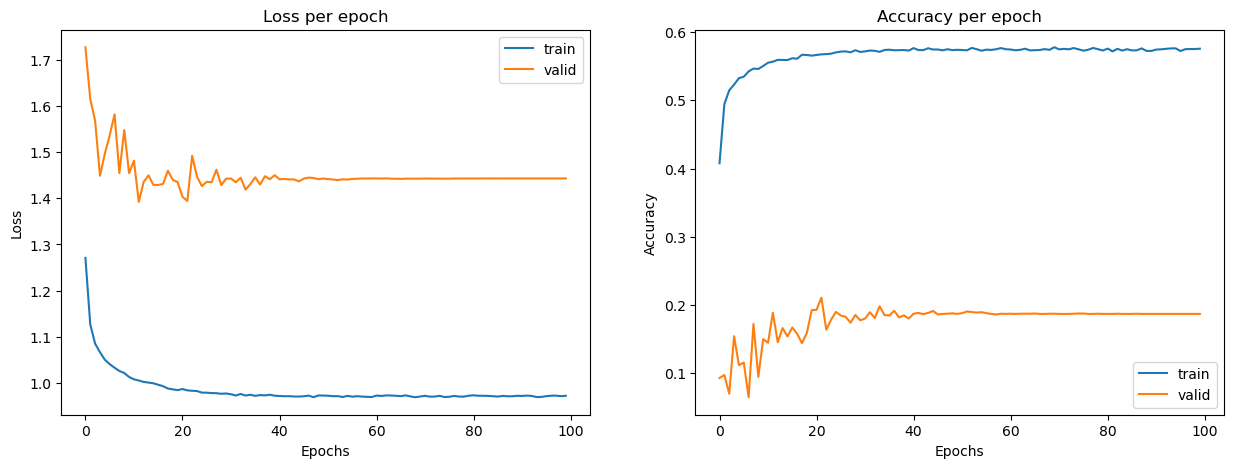

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 1s 256us/step
              precision    recall  f1-score   support

           0       0.68      0.82      0.74     46137
           1       0.12      0.68      0.21      3050
           2       0.28      0.45      0.35     17500
           3       0.72      0.19      0.30     45097

    accuracy                           0.50    111784
   macro avg       0.45      0.53      0.40    111784
weighted avg       0.62      0.50      0.49    111784
 




Classe prédite      0     1      2     3
Classe réelle                           
0               37977  2941   3364  1855
1                 234  2062    694    60
2                2107  6219   7869  1305
3               15546  5299  15767  8485



 Accuracy :  50.0
Epoch 1/100


/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.3338 - sparse_categorical_accuracy: 0.3527 - val_loss: 1.7756 - val_sparse_categorical_accuracy: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1236 - sparse_categorical_accuracy: 0.4934 - val_loss: 1.6231 - val_sparse_categorical_accuracy: 0.0281 - learning_rate: 0.0010
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0796 - sparse_categorical_accuracy: 0.5209 - val_loss: 1.5549 - val_sparse_categorical_accuracy: 0.2008 - learning_rate: 0.0010
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0575 - sparse_categorical_accuracy: 0.5336 - val_loss: 1.5070 - val_sparse_categorical_accuracy: 0.1409 - learning_rate: 0.0010
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0417 - sparse_categorical_accuracy: 0.5377 - val_loss: 1.5581 - val_sparse_categorical_accuracy: 0.1216 - learning_rate: 0.0010
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.03

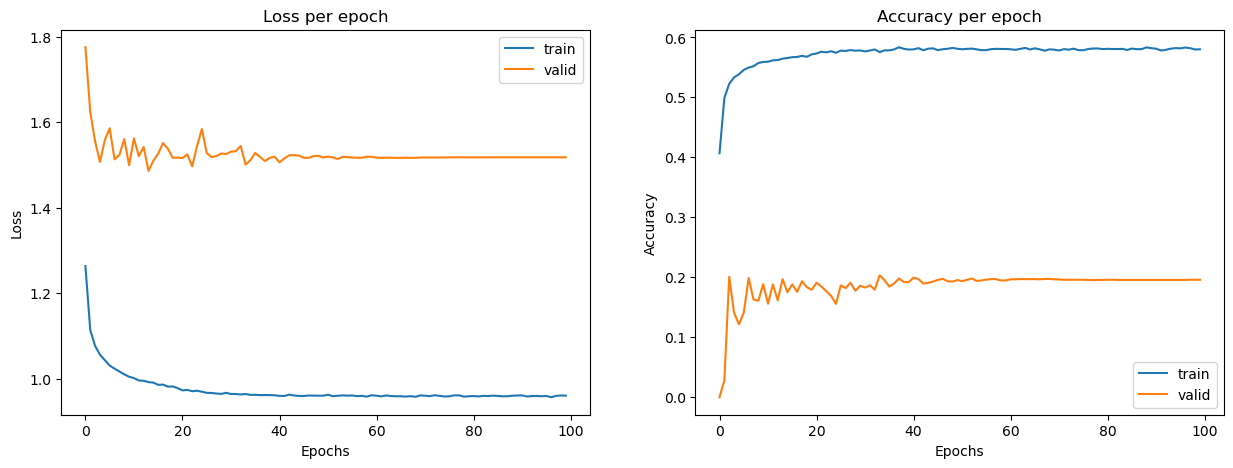

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 1s 266us/step
              precision    recall  f1-score   support

           0       0.68      0.82      0.74     46137
           1       0.12      0.68      0.20      3050
           2       0.29      0.44      0.35     17500
           3       0.74      0.19      0.31     45097

    accuracy                           0.50    111784
   macro avg       0.46      0.53      0.40    111784
weighted avg       0.63      0.50      0.49    111784
 




Classe prédite      0     1      2     3
Classe réelle                           
0               37957  2997   3457  1726
1                 240  2071    675    64
2                2048  6465   7655  1332
3               15523  5937  14922  8715



 Accuracy :  50.0


In [20]:
reductions = ["sum", "sum_over_batch_size", None]

for reduction in reductions :
    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=False,
        ignore_class=None,
        reduction = reduction,
        name="sparse_categorical_crossentropy",
    )

    model2 = Sequential()
    model2.add( Dense(units = 70, activation = 'relu', input_shape = (X_train.shape[1],)))
    model2.add(Dense(units = 140, activation = 'relu'))
    model2.add(Dropout(rate = 0.2))
    model2.add( Dense(units = 70, activation = 'relu'))
    model2.add(Dense(units = 35, activation = 'relu'))
    model2.add(Dropout(rate = 0.2))
    model2.add(Dense(units = 14, activation = 'relu'))
    model2.add(Dense(units = 4, activation = 'softmax'))

    
    model2.compile(loss = loss,
               optimizer = "adam",
               metrics = ['sparse_categorical_accuracy'])
    
    history2 = model2.fit(X_train_ru, y_train_ru, epochs = 100, batch_size = 512, validation_split = 0.1, callbacks = [reduce_learning_rate])
    
    print("\n Loss avec reduction :", reduction)
    
    plt.figure(figsize =(15, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history2.history['loss'], label = 'train')
    plt.plot(history2.history['val_loss'], label = 'valid')
    plt.xlabel("Epochs")
    plt.ylabel('Loss')
    plt.legend()
    plt.title("Loss per epoch")

    plt.subplot(1, 2, 2)
    plt.plot(history2.history['sparse_categorical_accuracy'], label = 'train')
    plt.plot(history2.history['val_sparse_categorical_accuracy'], label = 'valid')
    plt.xlabel("Epochs")
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title("Accuracy per epoch")

    plt.show()

    test_pred = model2.predict(X_test)
    test_pred_class = test_pred.argmax(axis=1)

    # Affichage des résultats
    print(classification_report(y_test, test_pred_class), '\n\n')

    display(pd.crosstab(y_test, test_pred_class, rownames = ['Classe réelle'], colnames = ['Classe prédite']))
    
    print('\n\n Accuracy : ', np.round(accuracy_score(y_test, test_pred_class), 2)*100)

La meilleure reduction semble être "sum".

### Modèle 3 : recherche de la meilleure activation

In [25]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=False,
        ignore_class=None,
        reduction="sum",
        name="sparse_categorical_crossentropy",
    )

Epoch 1/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 696.6569 - sparse_categorical_accuracy: 0.3098 - val_loss: 825.5879 - val_sparse_categorical_accuracy: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 586.1671 - sparse_categorical_accuracy: 0.4888 - val_loss: 759.2429 - val_sparse_categorical_accuracy: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 558.5837 - sparse_categorical_accuracy: 0.5176 - val_loss: 746.7781 - val_sparse_categorical_accuracy: 0.0046 - learning_rate: 0.0010
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 548.2394 - sparse_categorical_accuracy: 0.5266 - val_loss: 759.0732 - val_sparse_categorical_accuracy: 0.0254 - learning_rate: 0.0010
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 536.3779 - sparse_categorical_accuracy: 0.5382 - val_loss: 725.1232 - val_sparse_categorical_accuracy: 0.0885 - learning_rate: 0.0010
Epoch 6/100
65/65 ━━━━━━━━━

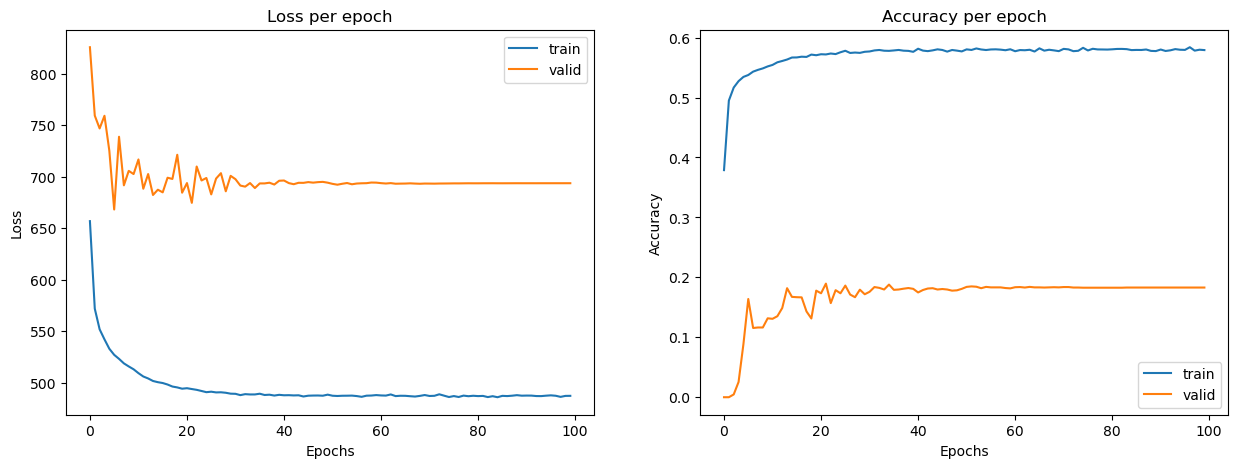

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 1s 299us/step
              precision    recall  f1-score   support

           0       0.68      0.82      0.74     46137
           1       0.12      0.67      0.20      3050
           2       0.28      0.45      0.35     17500
           3       0.73      0.19      0.30     45097

    accuracy                           0.50    111784
   macro avg       0.45      0.53      0.40    111784
weighted avg       0.62      0.50      0.49    111784
 




Classe prédite      0     1      2     3
Classe réelle                           
0               37757  3148   3427  1805
1                 227  2054    700    69
2                1977  6464   7800  1259
3               15350  5791  15557  8399



 Accuracy :  50.0
Epoch 1/100


/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 793.4584 - sparse_categorical_accuracy: 0.1809 - val_loss: 718.7310 - val_sparse_categorical_accuracy: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 702.7770 - sparse_categorical_accuracy: 0.2796 - val_loss: 810.6552 - val_sparse_categorical_accuracy: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 700.0129 - sparse_categorical_accuracy: 0.2802 - val_loss: 829.5953 - val_sparse_categorical_accuracy: 0.0000e+00 - learning_rate: 0.0010
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 697.5914 - sparse_categorical_accuracy: 0.3033 - val_loss: 815.0175 - val_sparse_categorical_accuracy: 0.0000e+00 - learning_rate: 0.0010
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 667.5546 - sparse_categorical_accuracy: 0.4231 - val_loss: 797.1810 - val_sparse_categorical_accuracy: 0.0000e+00 - learning_rate: 0.0010
Epoch 6/100
61/65 ━━━━━━━━━

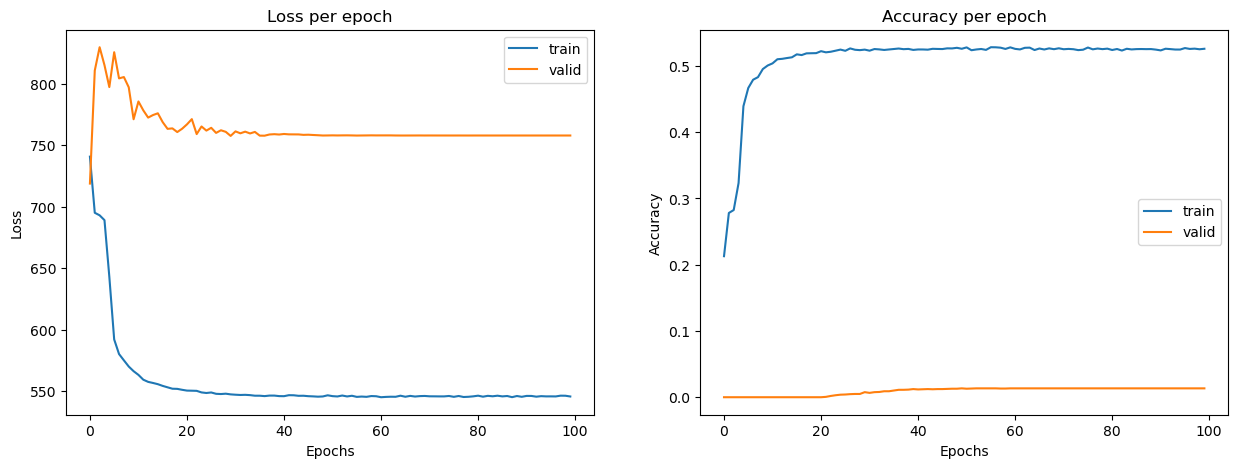

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 1s 333us/step
              precision    recall  f1-score   support

           0       0.67      0.79      0.72     46137
           1       0.10      0.64      0.18      3050
           2       0.22      0.46      0.30     17500
           3       0.61      0.02      0.03     45097

    accuracy                           0.42    111784
   macro avg       0.40      0.48      0.31    111784
weighted avg       0.56      0.42      0.36    111784
 




Classe prédite      0     1      2    3
Classe réelle                          
0               36302  3116   6348  371
1                 280  1961    801    8
2                2138  7164   8091  107
3               15528  6779  22035  755



 Accuracy :  42.0
Epoch 1/100


/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 656.9183 - sparse_categorical_accuracy: 0.3989 - val_loss: 778.1725 - val_sparse_categorical_accuracy: 0.1237 - learning_rate: 0.0010
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 561.3528 - sparse_categorical_accuracy: 0.5134 - val_loss: 746.0941 - val_sparse_categorical_accuracy: 0.1317 - learning_rate: 0.0010
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 546.4869 - sparse_categorical_accuracy: 0.5264 - val_loss: 770.0686 - val_sparse_categorical_accuracy: 0.1459 - learning_rate: 0.0010
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 539.0988 - sparse_categorical_accuracy: 0.5396 - val_loss: 715.5742 - val_sparse_categorical_accuracy: 0.1480 - learning_rate: 0.0010
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 535.5987 - sparse_categorical_accuracy: 0.5386 - val_loss: 742.7075 - val_sparse_categorical_accuracy: 0.1631 - learning_rate: 0.0010
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/s

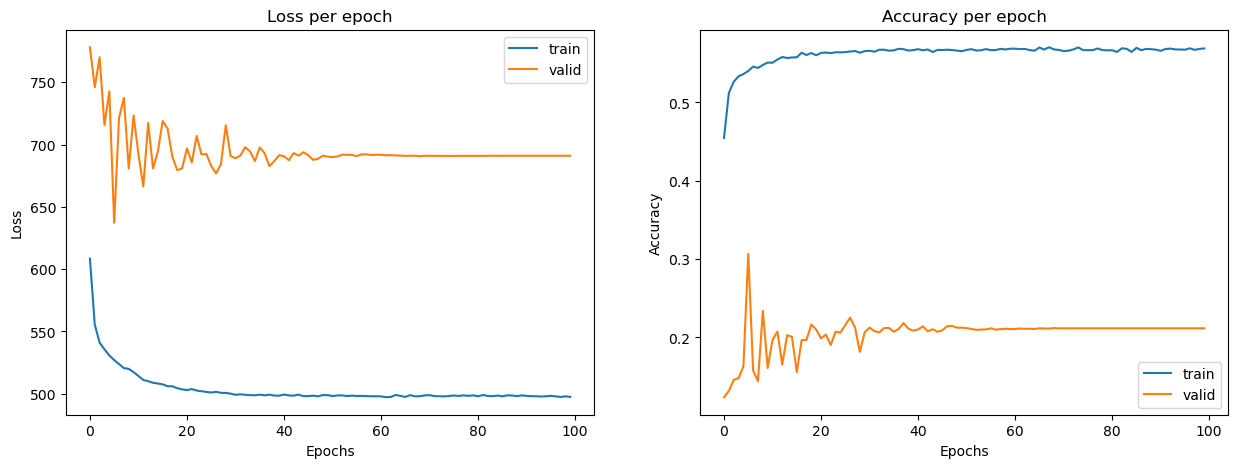

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 1s 361us/step
              precision    recall  f1-score   support

           0       0.68      0.82      0.74     46137
           1       0.12      0.66      0.20      3050
           2       0.30      0.44      0.36     17500
           3       0.73      0.21      0.33     45097

    accuracy                           0.51    111784
   macro avg       0.46      0.53      0.41    111784
weighted avg       0.62      0.51      0.50    111784
 




Classe prédite      0     1      2     3
Classe réelle                           
0               37703  3139   3181  2114
1                 253  2022    696    79
2                2083  6221   7753  1443
3               15549  6065  13885  9598



 Accuracy :  51.0
Epoch 1/100


/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 681.7422 - sparse_categorical_accuracy: 0.3609 - val_loss: 784.3976 - val_sparse_categorical_accuracy: 0.0016 - learning_rate: 0.0010
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 570.0563 - sparse_categorical_accuracy: 0.5002 - val_loss: 757.7012 - val_sparse_categorical_accuracy: 0.0524 - learning_rate: 0.0010
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 546.8998 - sparse_categorical_accuracy: 0.5236 - val_loss: 750.7584 - val_sparse_categorical_accuracy: 0.1114 - learning_rate: 0.0010
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 535.1844 - sparse_categorical_accuracy: 0.5352 - val_loss: 703.0078 - val_sparse_categorical_accuracy: 0.1551 - learning_rate: 0.0010
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 532.8248 - sparse_categorical_accuracy: 0.5384 - val_loss: 715.3922 - val_sparse_categorical_accuracy: 0.1352 - learning_rate: 0.0010
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/s

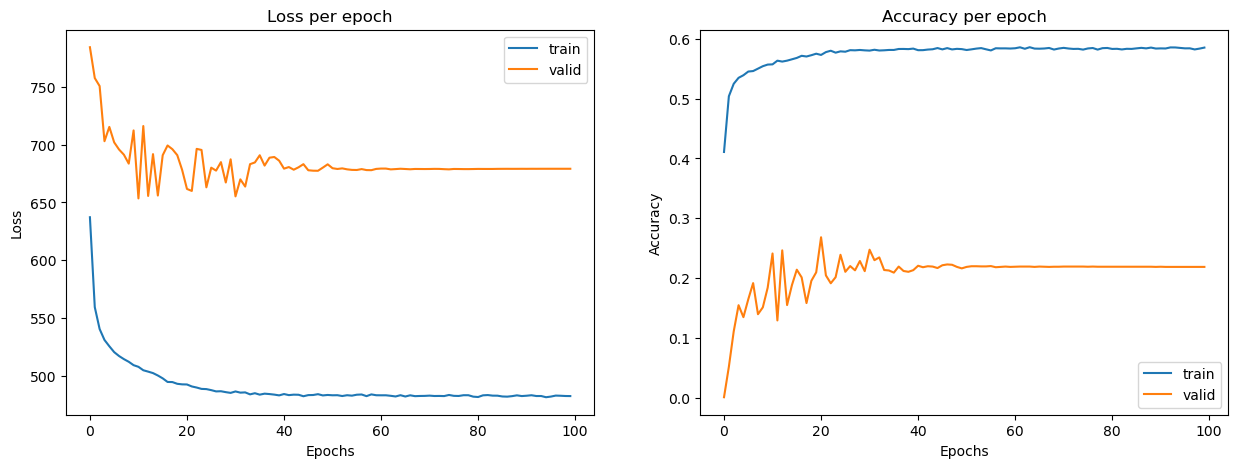

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 1s 310us/step
              precision    recall  f1-score   support

           0       0.68      0.82      0.75     46137
           1       0.12      0.68      0.20      3050
           2       0.30      0.44      0.36     17500
           3       0.74      0.23      0.35     45097

    accuracy                           0.52    111784
   macro avg       0.46      0.54      0.41    111784
weighted avg       0.63      0.52      0.51    111784
 




Classe prédite      0     1      2      3
Classe réelle                            
0               38012  3014   3150   1961
1                 226  2084    661     79
2                2057  6327   7639   1477
3               15346  5909  13635  10207



 Accuracy :  52.0
Epoch 1/100


/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 680.2032 - sparse_categorical_accuracy: 0.3519 - val_loss: 736.6356 - val_sparse_categorical_accuracy: 0.0554 - learning_rate: 0.0010
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 565.1691 - sparse_categorical_accuracy: 0.5135 - val_loss: 733.3984 - val_sparse_categorical_accuracy: 0.0748 - learning_rate: 0.0010
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 544.5706 - sparse_categorical_accuracy: 0.5307 - val_loss: 676.0696 - val_sparse_categorical_accuracy: 0.2024 - learning_rate: 0.0010
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 535.9013 - sparse_categorical_accuracy: 0.5387 - val_loss: 689.2105 - val_sparse_categorical_accuracy: 0.1379 - learning_rate: 0.0010
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 531.2825 - sparse_categorical_accuracy: 0.5406 - val_loss: 759.4090 - val_sparse_categorical_accuracy: 0.1287 - learning_rate: 0.0010
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/s

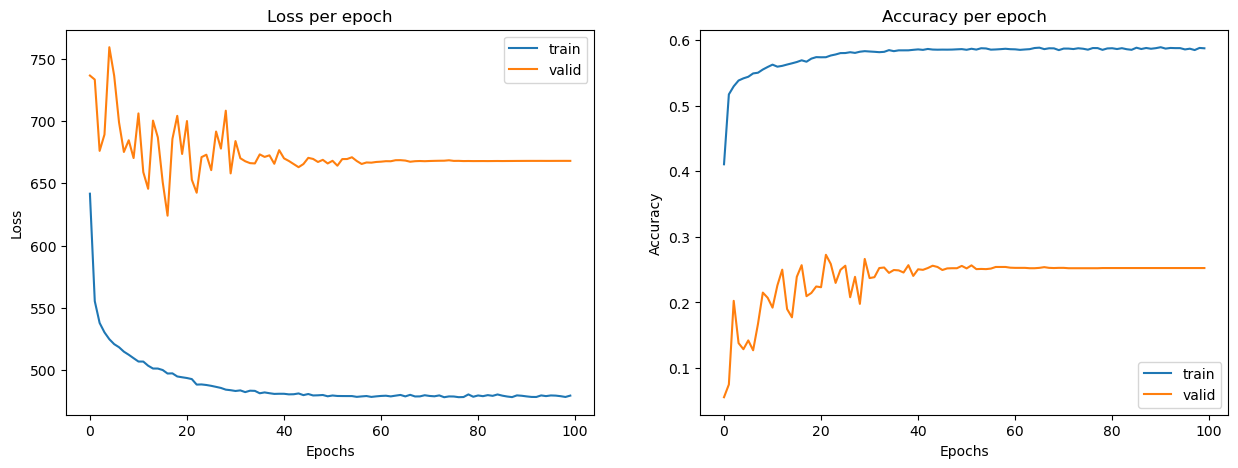

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 1s 316us/step
              precision    recall  f1-score   support

           0       0.69      0.83      0.75     46137
           1       0.13      0.66      0.21      3050
           2       0.31      0.45      0.37     17500
           3       0.74      0.25      0.37     45097

    accuracy                           0.53    111784
   macro avg       0.47      0.55      0.43    111784
weighted avg       0.64      0.53      0.52    111784
 




Classe prédite      0     1      2      3
Classe réelle                            
0               38227  2661   3182   2067
1                 228  2005    723     94
2                1998  5914   7863   1725
3               15166  5320  13319  11292



 Accuracy :  53.0
Epoch 1/100


/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 672.3078 - sparse_categorical_accuracy: 0.3943 - val_loss: 719.5959 - val_sparse_categorical_accuracy: 0.1325 - learning_rate: 0.0010
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 564.8367 - sparse_categorical_accuracy: 0.5083 - val_loss: 732.6321 - val_sparse_categorical_accuracy: 0.1625 - learning_rate: 0.0010
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 548.3511 - sparse_categorical_accuracy: 0.5250 - val_loss: 702.8555 - val_sparse_categorical_accuracy: 0.1661 - learning_rate: 0.0010
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 536.6160 - sparse_categorical_accuracy: 0.5385 - val_loss: 702.2134 - val_sparse_categorical_accuracy: 0.1811 - learning_rate: 0.0010
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 534.0541 - sparse_categorical_accuracy: 0.5378 - val_loss: 743.2867 - val_sparse_categorical_accuracy: 0.1598 - learning_rate: 0.0010
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/s

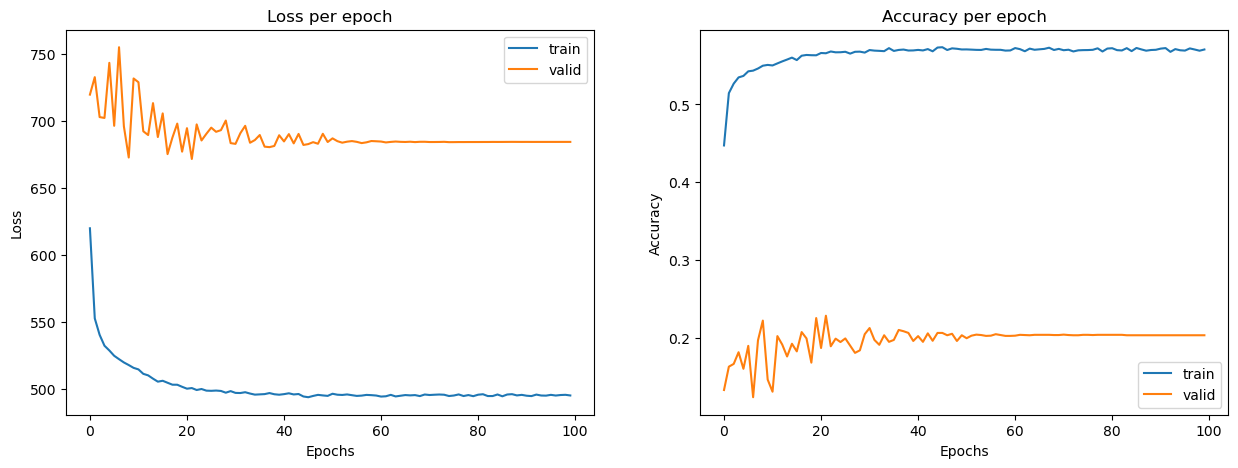

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 1s 368us/step
              precision    recall  f1-score   support

           0       0.68      0.82      0.74     46137
           1       0.12      0.65      0.21      3050
           2       0.30      0.46      0.36     17500
           3       0.73      0.21      0.33     45097

    accuracy                           0.52    111784
   macro avg       0.46      0.54      0.41    111784
weighted avg       0.62      0.52      0.50    111784
 




Classe prédite      0     1      2     3
Classe réelle                           
0               38045  2700   3327  2065
1                 260  1972    743    75
2                2119  5966   7980  1435
3               15647  5361  14485  9604



 Accuracy :  52.0
Epoch 1/100


/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 795.5837 - sparse_categorical_accuracy: 0.3406 - val_loss: 777.0609 - val_sparse_categorical_accuracy: 0.1041 - learning_rate: 0.0010
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 596.4659 - sparse_categorical_accuracy: 0.4804 - val_loss: 807.3824 - val_sparse_categorical_accuracy: 0.0473 - learning_rate: 0.0010
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 568.7919 - sparse_categorical_accuracy: 0.5001 - val_loss: 804.6833 - val_sparse_categorical_accuracy: 0.0839 - learning_rate: 0.0010
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 558.7791 - sparse_categorical_accuracy: 0.5092 - val_loss: 734.0971 - val_sparse_categorical_accuracy: 0.1415 - learning_rate: 0.0010
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 544.0473 - sparse_categorical_accuracy: 0.5268 - val_loss: 760.9877 - val_sparse_categorical_accuracy: 0.1278 - learning_rate: 0.0010
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/s

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 1s 347us/step
              precision    recall  f1-score   support

           0       0.68      0.82      0.74     46137
           1       0.12      0.64      0.21      3050
           2       0.30      0.47      0.37     17500
           3       0.74      0.22      0.34     45097

    accuracy                           0.52    111784
   macro avg       0.46      0.54      0.41    111784
weighted avg       0.63      0.52      0.51    111784
 




Classe prédite      0     1      2     3
Classe réelle                           
0               37639  2754   3671  2073
1                 234  1942    788    86
2                2004  5790   8309  1397
3               15165  5158  14871  9903



 Accuracy :  52.0
Epoch 1/100


/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 682.0423 - sparse_categorical_accuracy: 0.3698 - val_loss: 782.3712 - val_sparse_categorical_accuracy: 0.0522 - learning_rate: 0.0010
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 577.4957 - sparse_categorical_accuracy: 0.4949 - val_loss: 762.3727 - val_sparse_categorical_accuracy: 0.0901 - learning_rate: 0.0010
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 552.9963 - sparse_categorical_accuracy: 0.5205 - val_loss: 788.9235 - val_sparse_categorical_accuracy: 0.0795 - learning_rate: 0.0010
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 538.9057 - sparse_categorical_accuracy: 0.5327 - val_loss: 657.8845 - val_sparse_categorical_accuracy: 0.2253 - learning_rate: 0.0010
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 531.4911 - sparse_categorical_accuracy: 0.5461 - val_loss: 753.6031 - val_sparse_categorical_accuracy: 0.1153 - learning_rate: 0.0010
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/s

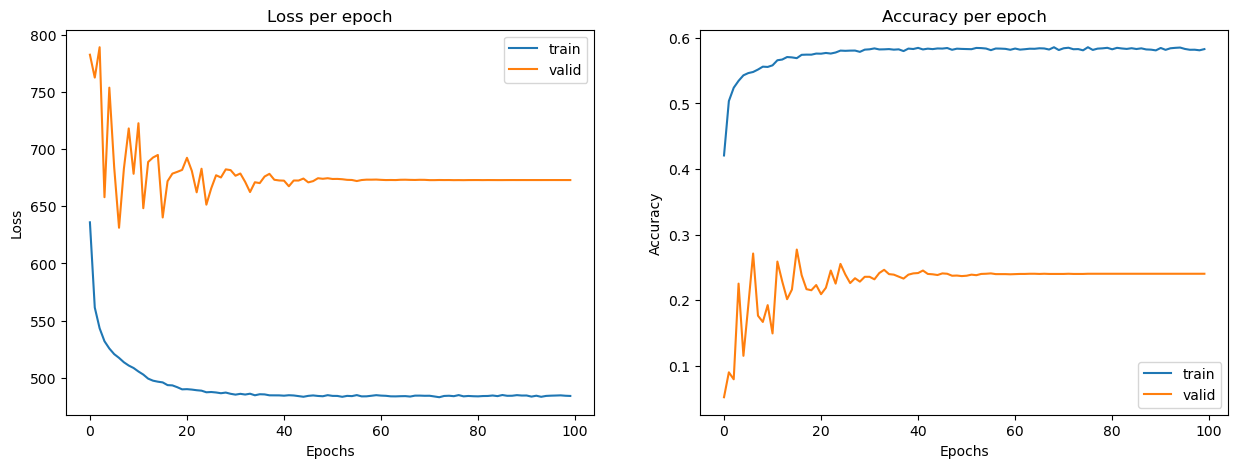

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 2s 430us/step
              precision    recall  f1-score   support

           0       0.69      0.82      0.75     46137
           1       0.13      0.65      0.21      3050
           2       0.30      0.45      0.36     17500
           3       0.73      0.25      0.37     45097

    accuracy                           0.53    111784
   macro avg       0.46      0.54      0.42    111784
weighted avg       0.63      0.53      0.52    111784
 




Classe prédite      0     1      2      3
Classe réelle                            
0               37790  2644   3289   2414
1                 228  1995    742     85
2                1973  5925   7952   1650
3               14703  5131  14204  11059



 Accuracy :  53.0


In [26]:
activations = ['relu', 'sigmoid', 'tanh', 'leaky_relu', 'swish', 'elu', 'selu', 'gelu']

for activation in activations :
    model3 = Sequential()
    model3.add( Dense(units = 70, activation = activation, input_shape = (X_train.shape[1],)))
    model3.add(Dense(units = 140, activation = activation))
    model3.add(Dropout(rate = 0.2))
    model3.add( Dense(units = 70, activation = activation))
    model3.add(Dense(units = 35, activation = activation))
    model3.add(Dropout(rate = 0.2))
    model3.add(Dense(units = 14, activation = activation))
    model3.add(Dense(units = 4, activation = 'softmax'))

    model3.compile(loss = loss,
               optimizer = "adam",
               metrics = ['sparse_categorical_accuracy'])
    
    history3 = model3.fit(X_train_ru, y_train_ru, epochs = 100, batch_size = 512, validation_split = 0.1, callbacks = [reduce_learning_rate])
    
    print("\n Modèle avec activation :", activation)
    
    plt.figure(figsize =(15, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history3.history['loss'], label = 'train')
    plt.plot(history3.history['val_loss'], label = 'valid')
    plt.xlabel("Epochs")
    plt.ylabel('Loss')
    plt.legend()
    plt.title("Loss per epoch")

    plt.subplot(1, 2, 2)
    plt.plot(history3.history['sparse_categorical_accuracy'], label = 'train')
    plt.plot(history3.history['val_sparse_categorical_accuracy'], label = 'valid')
    plt.xlabel("Epochs")
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title("Accuracy per epoch")

    plt.show()
    test_pred = model3.predict(X_test)
    test_pred_class = test_pred.argmax(axis=1)

    # Affichage des résultats
    print(classification_report(y_test, test_pred_class), '\n\n')

    display(pd.crosstab(y_test, test_pred_class, rownames = ['Classe réelle'], colnames = ['Classe prédite']))
    
    print('\n\n Accuracy : ', np.round(accuracy_score(y_test, test_pred_class), 2)*100)

La meilleure activation est relu.

### Modèle 4 : ajout de kernel_initializer

In [27]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=False,
        ignore_class=None,
        reduction="sum",
        name="sparse_categorical_crossentropy",
    )

Epoch 1/100


/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4549782.0000 - sparse_categorical_accuracy: 0.2811 - val_loss: 540132.2500 - val_sparse_categorical_accuracy: 0.2450 - learning_rate: 0.0010
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1234449.3750 - sparse_categorical_accuracy: 0.2900 - val_loss: 352015.2188 - val_sparse_categorical_accuracy: 0.0407 - learning_rate: 0.0010
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 529534.8125 - sparse_categorical_accuracy: 0.2841 - val_loss: 146613.6719 - val_sparse_categorical_accuracy: 0.0205 - learning_rate: 0.0010
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 268380.8438 - sparse_categorical_accuracy: 0.2832 - val_loss: 28825.3906 - val_sparse_categorical_accuracy: 0.0224 - learning_rate: 0.0010
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 141061.9062 - sparse_categorical_accuracy: 0.2777 - val_loss: 3637.7080 - val_sparse_categorical_accuracy: 0.0036 - learning_rate: 0.0010
Epoch 6/100
65/65 

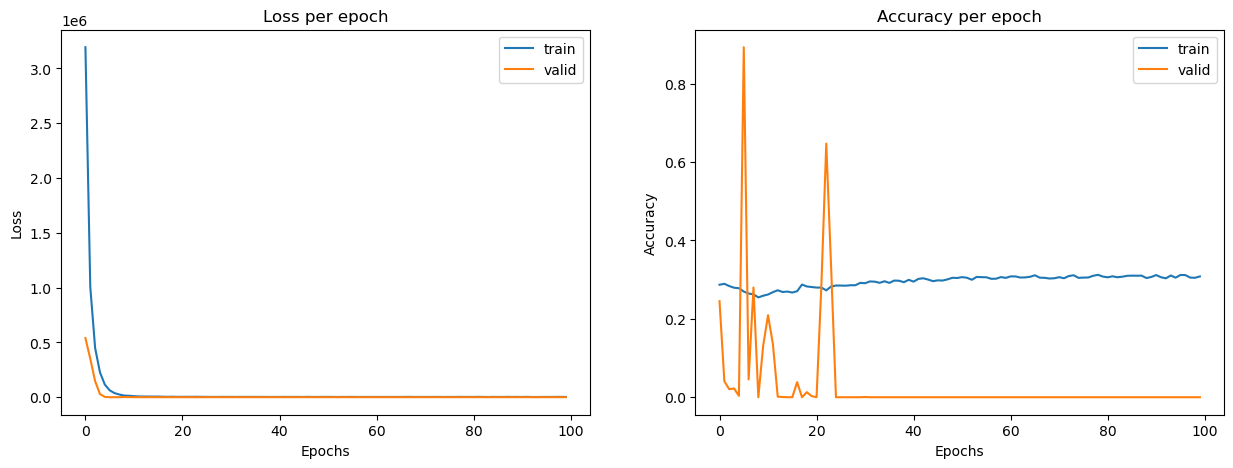

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 1s 338us/step
              precision    recall  f1-score   support

           0       0.48      0.70      0.57     46137
           1       0.06      0.17      0.09      3050
           2       0.21      0.42      0.28     17500
           3       0.00      0.00      0.00     45097

    accuracy                           0.36    111784
   macro avg       0.19      0.32      0.23    111784
weighted avg       0.23      0.36      0.28    111784
 




/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

Classe prédite      0     1      2
Classe réelle                     
0               32421  2185  11531
1                1220   524   1306
2                7956  2140   7404
3               25697  4083  15317



 Accuracy :  36.0
Epoch 1/100


/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 9219772416.0000 - sparse_categorical_accuracy: 0.2789 - val_loss: 3047947520.0000 - val_sparse_categorical_accuracy: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1098851328.0000 - sparse_categorical_accuracy: 0.2726 - val_loss: 151116640.0000 - val_sparse_categorical_accuracy: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 247225792.0000 - sparse_categorical_accuracy: 0.2635 - val_loss: 92607904.0000 - val_sparse_categorical_accuracy: 0.0000e+00 - learning_rate: 0.0010
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 227769904.0000 - sparse_categorical_accuracy: 0.2578 - val_loss: 72758048.0000 - val_sparse_categorical_accuracy: 0.0000e+00 - learning_rate: 0.0010
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 201364096.0000 - sparse_categorical_accuracy: 0.2626 - val_loss: 74517736.0000 - val_sparse_categorical_accuracy: 0.

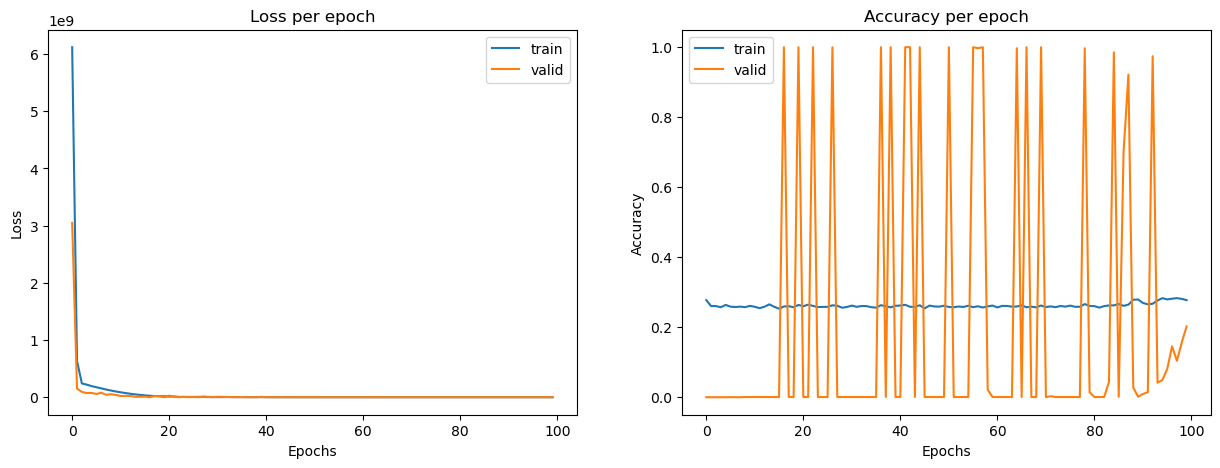

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 1s 317us/step
              precision    recall  f1-score   support

           0       0.43      0.41      0.42     46137
           1       0.03      0.44      0.06      3050
           2       0.00      0.00      0.00     17500
           3       0.40      0.21      0.28     45097

    accuracy                           0.26    111784
   macro avg       0.22      0.26      0.19    111784
weighted avg       0.34      0.26      0.29    111784
 




/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

Classe prédite      0      1     3
Classe réelle                     
0               18744  17677  9716
1                1100   1345   605
2                6368   7417  3715
3               16971  18604  9522



 Accuracy :  26.0
Epoch 1/100


/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1360040.0000 - sparse_categorical_accuracy: 0.2835 - val_loss: 281312.6250 - val_sparse_categorical_accuracy: 0.3289 - learning_rate: 0.0010
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 475669.0938 - sparse_categorical_accuracy: 0.2830 - val_loss: 165503.3750 - val_sparse_categorical_accuracy: 0.1756 - learning_rate: 0.0010
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 192086.3438 - sparse_categorical_accuracy: 0.2811 - val_loss: 72383.0781 - val_sparse_categorical_accuracy: 0.1694 - learning_rate: 0.0010
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 71624.9609 - sparse_categorical_accuracy: 0.2686 - val_loss: 17917.4414 - val_sparse_categorical_accuracy: 0.5141 - learning_rate: 0.0010
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 25109.3359 - sparse_categorical_accuracy: 0.2348 - val_loss: 4366.1782 - val_sparse_categorical_accuracy: 0.7665 - learning_rate: 0.0010
Epoch 6/100
65/65 ━━━━

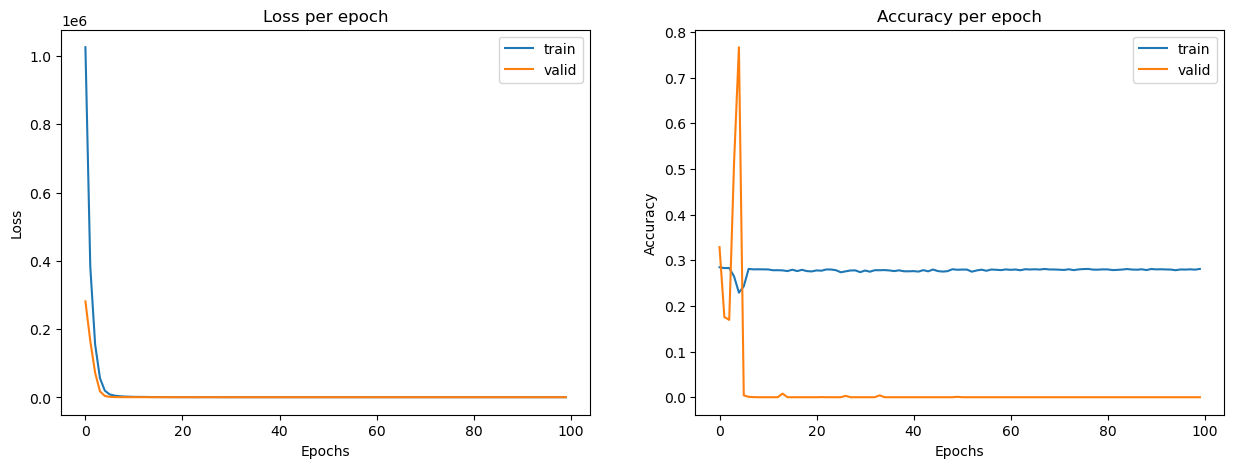

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 1s 361us/step
              precision    recall  f1-score   support

           0       0.44      0.01      0.02     46137
           1       0.03      0.99      0.05      3050
           2       0.16      0.00      0.00     17500
           3       0.00      0.00      0.00     45097

    accuracy                           0.03    111784
   macro avg       0.16      0.25      0.02    111784
weighted avg       0.21      0.03      0.01    111784
 




/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

Classe prédite    0      1   2
Classe réelle                 
0               353  45763  21
1                35   3012   3
2               156  17336   8
3               265  44814  18



 Accuracy :  3.0
Epoch 1/100


/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 676.7677 - sparse_categorical_accuracy: 0.3628 - val_loss: 774.6523 - val_sparse_categorical_accuracy: 0.0677 - learning_rate: 0.0010
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 563.9158 - sparse_categorical_accuracy: 0.5049 - val_loss: 704.1466 - val_sparse_categorical_accuracy: 0.1601 - learning_rate: 0.0010
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 545.7751 - sparse_categorical_accuracy: 0.5272 - val_loss: 708.6150 - val_sparse_categorical_accuracy: 0.1194 - learning_rate: 0.0010
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 538.6558 - sparse_categorical_accuracy: 0.5307 - val_loss: 675.3923 - val_sparse_categorical_accuracy: 0.2016 - learning_rate: 0.0010
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 531.7987 - sparse_categorical_accuracy: 0.5414 - val_loss: 712.5759 - val_sparse_categorical_accuracy: 0.1461 - learning_rate: 0.0010
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/s

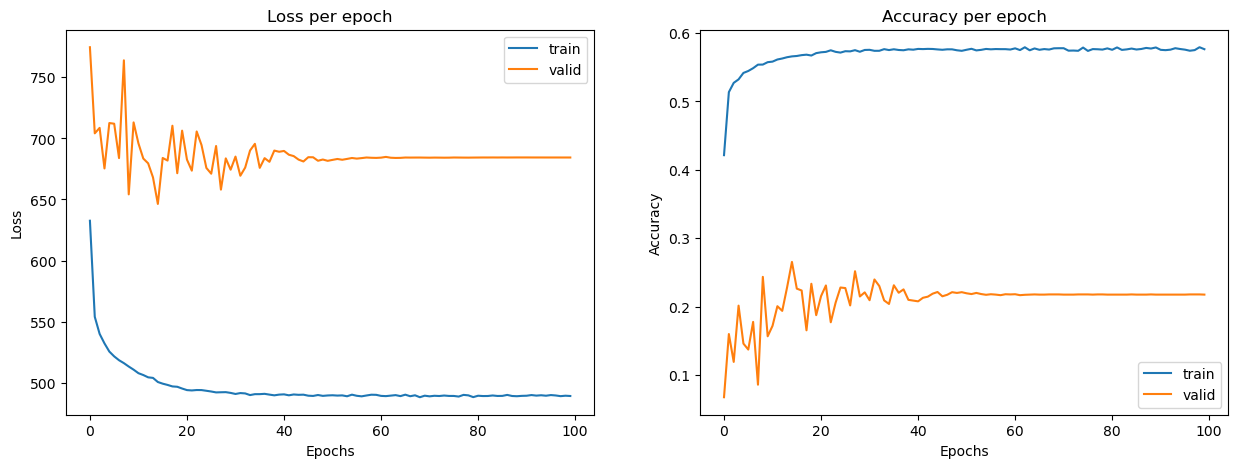

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 1s 341us/step
              precision    recall  f1-score   support

           0       0.68      0.82      0.75     46137
           1       0.12      0.65      0.21      3050
           2       0.30      0.46      0.37     17500
           3       0.73      0.22      0.34     45097

    accuracy                           0.52    111784
   macro avg       0.46      0.54      0.41    111784
weighted avg       0.63      0.52      0.51    111784
 




Classe prédite      0     1      2     3
Classe réelle                           
0               37810  2799   3325  2203
1                 249  1982    739    80
2                2073  5837   8137  1453
3               15234  5321  14671  9871



 Accuracy :  52.0
Epoch 1/100


/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 682.9156 - sparse_categorical_accuracy: 0.3493 - val_loss: 807.3620 - val_sparse_categorical_accuracy: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 575.1081 - sparse_categorical_accuracy: 0.5024 - val_loss: 711.3846 - val_sparse_categorical_accuracy: 0.1196 - learning_rate: 0.0010
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 547.5569 - sparse_categorical_accuracy: 0.5271 - val_loss: 745.7318 - val_sparse_categorical_accuracy: 0.1054 - learning_rate: 0.0010
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 538.2610 - sparse_categorical_accuracy: 0.5367 - val_loss: 718.9865 - val_sparse_categorical_accuracy: 0.1431 - learning_rate: 0.0010
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 529.0881 - sparse_categorical_accuracy: 0.5413 - val_loss: 697.8665 - val_sparse_categorical_accuracy: 0.1407 - learning_rate: 0.0010
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3

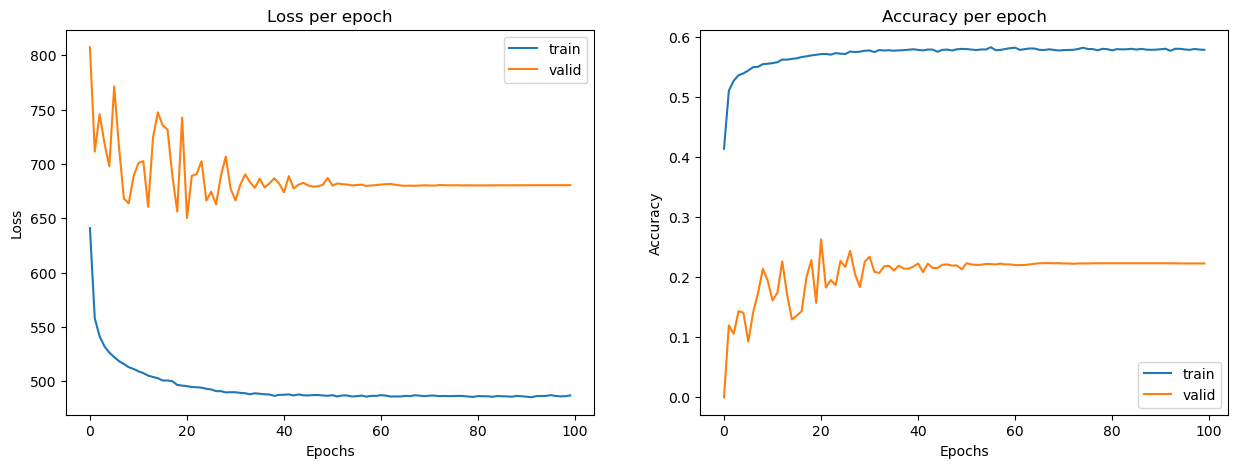

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 1s 378us/step
              precision    recall  f1-score   support

           0       0.68      0.82      0.75     46137
           1       0.13      0.65      0.21      3050
           2       0.30      0.46      0.36     17500
           3       0.74      0.22      0.34     45097

    accuracy                           0.52    111784
   macro avg       0.46      0.54      0.42    111784
weighted avg       0.63      0.52      0.51    111784
 




Classe prédite      0     1      2      3
Classe réelle                            
0               38059  2633   3361   2084
1                 248  1996    731     75
2                2089  5896   8048   1467
3               15358  5145  14511  10083



 Accuracy :  52.0
Epoch 1/100


/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 750.7834 - sparse_categorical_accuracy: 0.3240 - val_loss: 822.2302 - val_sparse_categorical_accuracy: 5.4630e-04 - learning_rate: 0.0010
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 605.7491 - sparse_categorical_accuracy: 0.4586 - val_loss: 808.2352 - val_sparse_categorical_accuracy: 0.0191 - learning_rate: 0.0010
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 571.1922 - sparse_categorical_accuracy: 0.4967 - val_loss: 777.2697 - val_sparse_categorical_accuracy: 0.0426 - learning_rate: 0.0010
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 557.1675 - sparse_categorical_accuracy: 0.5122 - val_loss: 712.1277 - val_sparse_categorical_accuracy: 0.1131 - learning_rate: 0.0010
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 549.9056 - sparse_categorical_accuracy: 0.5243 - val_loss: 740.4928 - val_sparse_categorical_accuracy: 0.0844 - learning_rate: 0.0010
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3

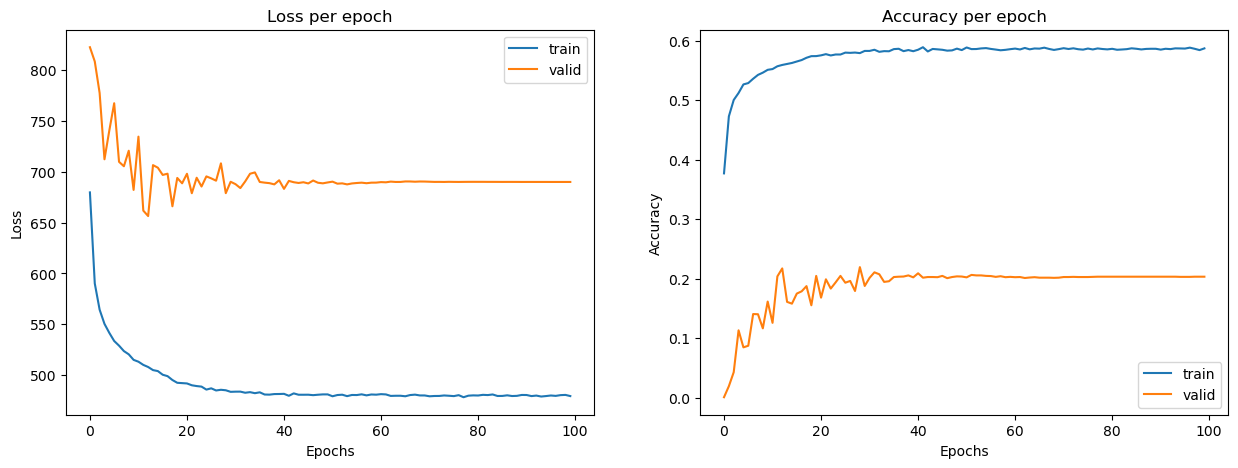

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 2s 445us/step
              precision    recall  f1-score   support

           0       0.68      0.83      0.75     46137
           1       0.12      0.66      0.21      3050
           2       0.30      0.46      0.36     17500
           3       0.76      0.21      0.33     45097

    accuracy                           0.52    111784
   macro avg       0.47      0.54      0.41    111784
weighted avg       0.64      0.52      0.50    111784
 




Classe prédite      0     1      2     3
Classe réelle                           
0               38219  2826   3453  1639
1                 223  2008    755    64
2                2001  6152   8018  1329
3               15512  5437  14700  9448



 Accuracy :  52.0
Epoch 1/100


/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 773.4373 - sparse_categorical_accuracy: 0.3222 - val_loss: 761.5453 - val_sparse_categorical_accuracy: 0.0279 - learning_rate: 0.0010
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 600.3409 - sparse_categorical_accuracy: 0.4670 - val_loss: 746.1664 - val_sparse_categorical_accuracy: 0.0609 - learning_rate: 0.0010
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 567.7832 - sparse_categorical_accuracy: 0.5080 - val_loss: 738.1705 - val_sparse_categorical_accuracy: 0.1011 - learning_rate: 0.0010
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 556.6829 - sparse_categorical_accuracy: 0.5063 - val_loss: 727.4158 - val_sparse_categorical_accuracy: 0.1311 - learning_rate: 0.0010
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 543.8832 - sparse_categorical_accuracy: 0.5274 - val_loss: 703.6544 - val_sparse_categorical_accuracy: 0.1437 - learning_rate: 0.0010
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/s

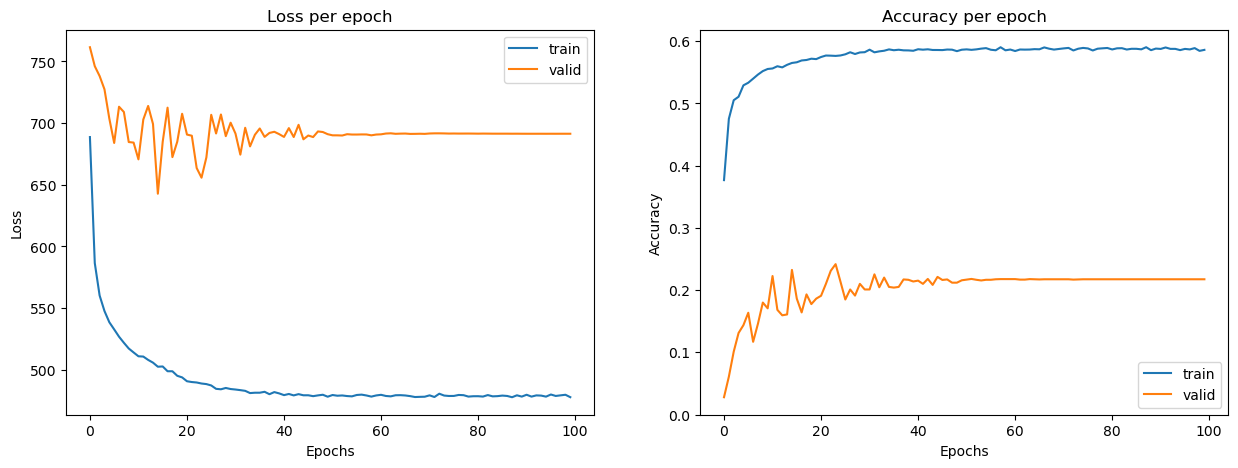

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 1s 352us/step
              precision    recall  f1-score   support

           0       0.68      0.83      0.75     46137
           1       0.12      0.68      0.20      3050
           2       0.29      0.42      0.35     17500
           3       0.74      0.22      0.33     45097

    accuracy                           0.51    111784
   macro avg       0.46      0.54      0.41    111784
weighted avg       0.63      0.51      0.50    111784
 




Classe prédite      0     1      2     3
Classe réelle                           
0               38209  2897   3093  1938
1                 238  2066    668    78
2                2031  6588   7374  1507
3               15523  5869  13925  9780



 Accuracy :  51.0
Epoch 1/100


/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 669.3314 - sparse_categorical_accuracy: 0.3660 - val_loss: 736.1900 - val_sparse_categorical_accuracy: 0.1448 - learning_rate: 0.0010
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 561.2407 - sparse_categorical_accuracy: 0.5047 - val_loss: 745.7390 - val_sparse_categorical_accuracy: 0.1579 - learning_rate: 0.0010
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 544.4084 - sparse_categorical_accuracy: 0.5262 - val_loss: 674.2209 - val_sparse_categorical_accuracy: 0.2188 - learning_rate: 0.0010
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 530.7586 - sparse_categorical_accuracy: 0.5430 - val_loss: 762.4858 - val_sparse_categorical_accuracy: 0.1221 - learning_rate: 0.0010
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 526.7498 - sparse_categorical_accuracy: 0.5431 - val_loss: 708.5069 - val_sparse_categorical_accuracy: 0.1669 - learning_rate: 0.0010
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/s

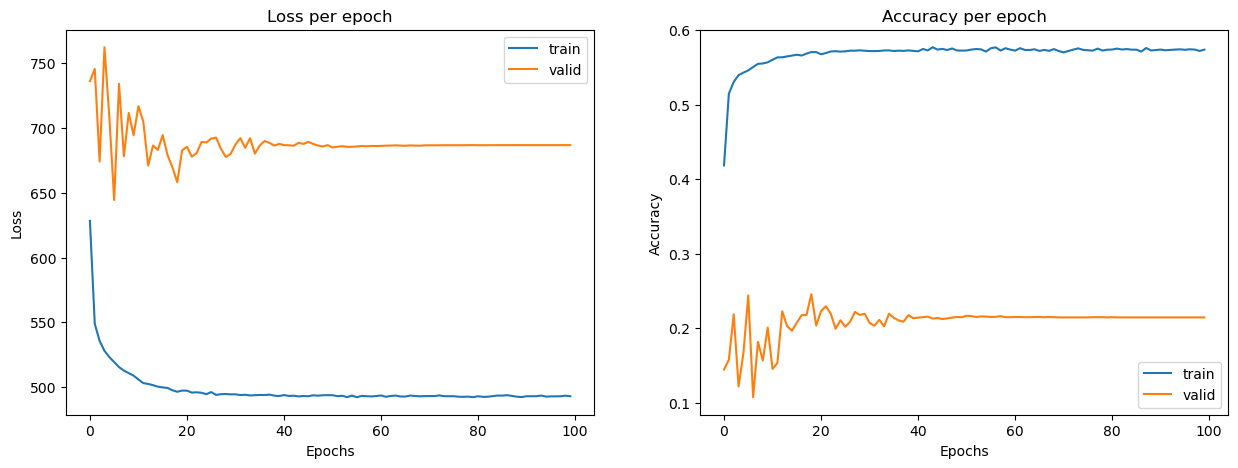

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 1s 312us/step
              precision    recall  f1-score   support

           0       0.68      0.83      0.74     46137
           1       0.12      0.66      0.21      3050
           2       0.30      0.45      0.36     17500
           3       0.74      0.21      0.33     45097

    accuracy                           0.51    111784
   macro avg       0.46      0.54      0.41    111784
weighted avg       0.63      0.51      0.50    111784
 




Classe prédite      0     1      2     3
Classe réelle                           
0               38179  2736   3388  1834
1                 246  2024    691    89
2                2128  6117   7805  1450
3               15900  5463  14232  9502



 Accuracy :  51.0
Epoch 1/100


/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 676.4614 - sparse_categorical_accuracy: 0.3631 - val_loss: 758.4915 - val_sparse_categorical_accuracy: 0.0145 - learning_rate: 0.0010
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 570.4122 - sparse_categorical_accuracy: 0.5039 - val_loss: 695.3830 - val_sparse_categorical_accuracy: 0.1011 - learning_rate: 0.0010
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 541.3705 - sparse_categorical_accuracy: 0.5329 - val_loss: 682.4562 - val_sparse_categorical_accuracy: 0.1300 - learning_rate: 0.0010
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 534.1111 - sparse_categorical_accuracy: 0.5348 - val_loss: 717.4890 - val_sparse_categorical_accuracy: 0.1131 - learning_rate: 0.0010
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 529.0314 - sparse_categorical_accuracy: 0.5396 - val_loss: 706.2931 - val_sparse_categorical_accuracy: 0.1071 - learning_rate: 0.0010
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/s

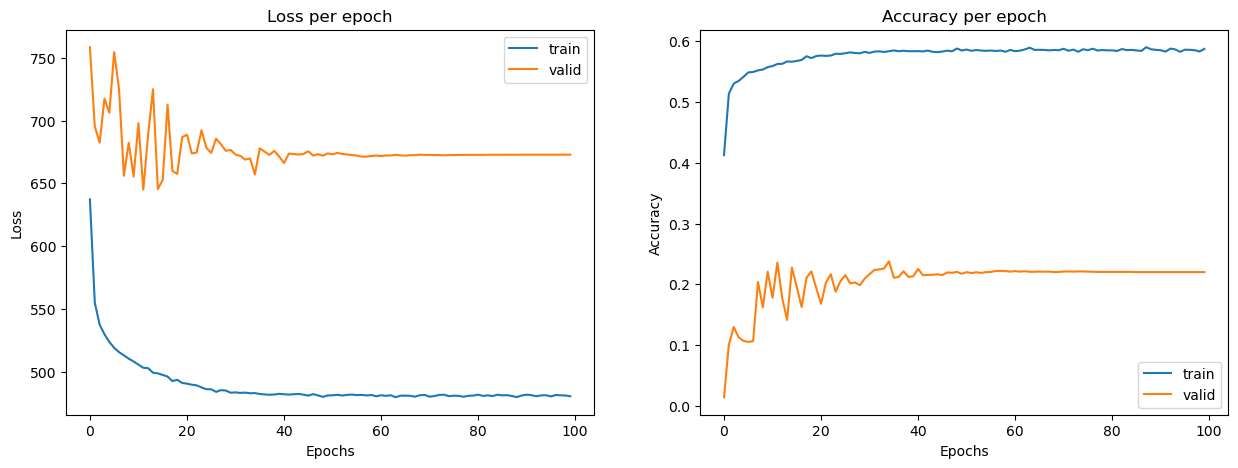

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 1s 326us/step
              precision    recall  f1-score   support

           0       0.68      0.83      0.75     46137
           1       0.13      0.66      0.21      3050
           2       0.30      0.45      0.36     17500
           3       0.75      0.23      0.35     45097

    accuracy                           0.52    111784
   macro avg       0.47      0.54      0.42    111784
weighted avg       0.64      0.52      0.51    111784
 




Classe prédite      0     1      2      3
Classe réelle                            
0               38314  2654   3294   1875
1                 229  2022    722     77
2                2046  6008   7953   1493
3               15385  5329  14147  10236



 Accuracy :  52.0
Epoch 1/100


/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 660.6547 - sparse_categorical_accuracy: 0.3957 - val_loss: 772.2862 - val_sparse_categorical_accuracy: 8.1945e-04 - learning_rate: 0.0010
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 558.5098 - sparse_categorical_accuracy: 0.5135 - val_loss: 720.7217 - val_sparse_categorical_accuracy: 0.1087 - learning_rate: 0.0010
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 542.1476 - sparse_categorical_accuracy: 0.5278 - val_loss: 699.1141 - val_sparse_categorical_accuracy: 0.1104 - learning_rate: 0.0010
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 533.1442 - sparse_categorical_accuracy: 0.5410 - val_loss: 721.5787 - val_sparse_categorical_accuracy: 0.1491 - learning_rate: 0.0010
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 530.8847 - sparse_categorical_accuracy: 0.5410 - val_loss: 660.5164 - val_sparse_categorical_accuracy: 0.2303 - learning_rate: 0.0010
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4

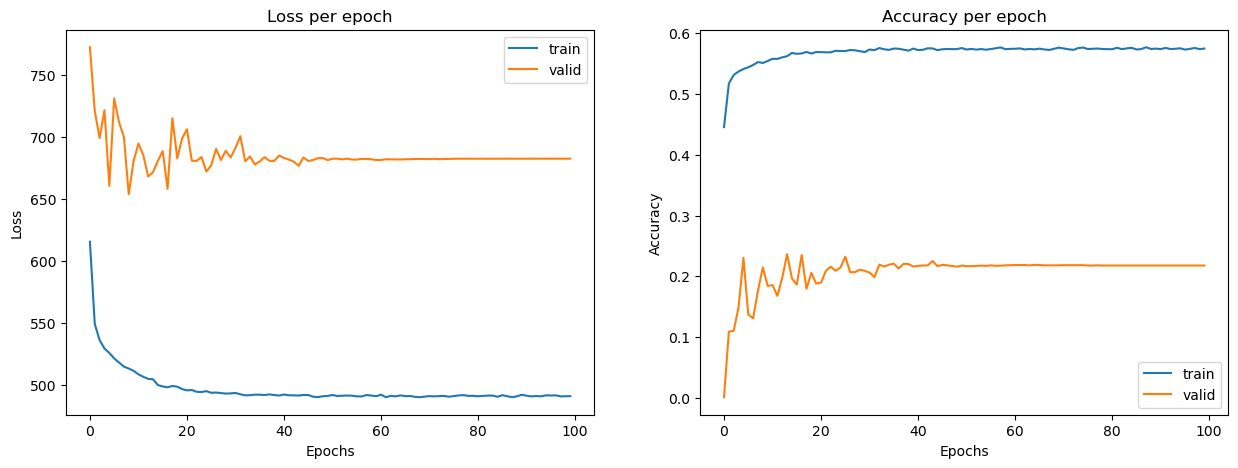

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 1s 362us/step
              precision    recall  f1-score   support

           0       0.68      0.82      0.74     46137
           1       0.12      0.67      0.20      3050
           2       0.30      0.44      0.36     17500
           3       0.74      0.21      0.33     45097

    accuracy                           0.51    111784
   macro avg       0.46      0.54      0.41    111784
weighted avg       0.63      0.51      0.50    111784
 




Classe prédite      0     1      2     3
Classe réelle                           
0               37964  2885   3373  1915
1                 245  2029    698    78
2                2097  6211   7761  1431
3               15551  5647  14246  9653



 Accuracy :  51.0
Epoch 1/100


/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 672.3749 - sparse_categorical_accuracy: 0.3792 - val_loss: 798.1111 - val_sparse_categorical_accuracy: 0.0158 - learning_rate: 0.0010
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 569.9831 - sparse_categorical_accuracy: 0.5063 - val_loss: 756.2946 - val_sparse_categorical_accuracy: 0.1060 - learning_rate: 0.0010
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 545.1078 - sparse_categorical_accuracy: 0.5321 - val_loss: 781.7822 - val_sparse_categorical_accuracy: 0.0773 - learning_rate: 0.0010
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 534.7276 - sparse_categorical_accuracy: 0.5418 - val_loss: 709.1351 - val_sparse_categorical_accuracy: 0.1267 - learning_rate: 0.0010
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 531.2643 - sparse_categorical_accuracy: 0.5450 - val_loss: 725.5732 - val_sparse_categorical_accuracy: 0.1519 - learning_rate: 0.0010
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/s

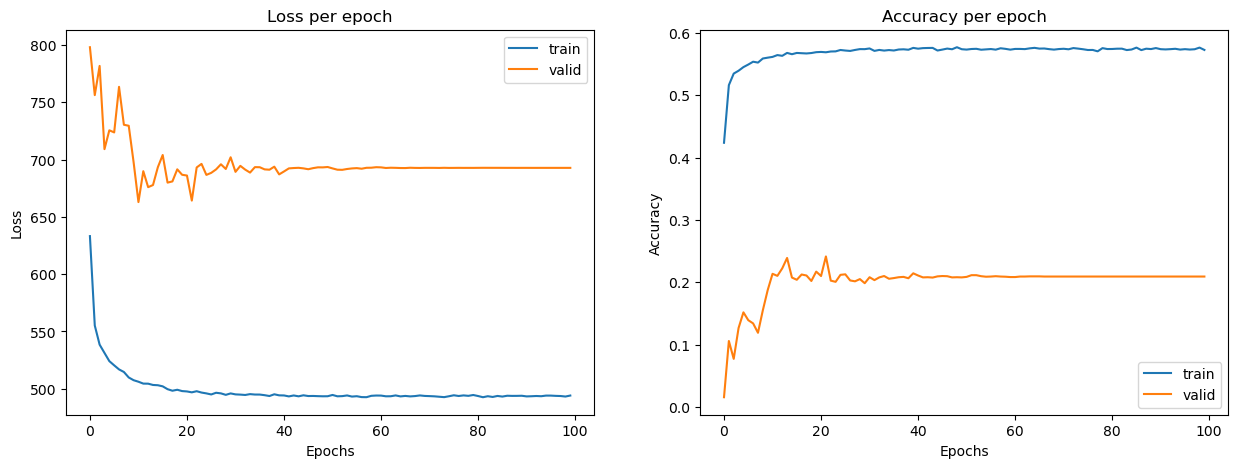

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 1s 401us/step
              precision    recall  f1-score   support

           0       0.68      0.82      0.74     46137
           1       0.12      0.67      0.20      3050
           2       0.30      0.44      0.35     17500
           3       0.72      0.22      0.33     45097

    accuracy                           0.51    111784
   macro avg       0.46      0.53      0.41    111784
weighted avg       0.62      0.51      0.50    111784
 




Classe prédite      0     1      2     3
Classe réelle                           
0               37733  2908   3331  2165
1                 247  2029    690    84
2                2101  6239   7703  1457
3               15372  5581  14375  9769



 Accuracy :  51.0
Epoch 1/100


/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 674.9515 - sparse_categorical_accuracy: 0.3802 - val_loss: 798.6319 - val_sparse_categorical_accuracy: 0.0022 - learning_rate: 0.0010
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 574.9308 - sparse_categorical_accuracy: 0.4956 - val_loss: 762.0036 - val_sparse_categorical_accuracy: 0.0830 - learning_rate: 0.0010
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 550.5712 - sparse_categorical_accuracy: 0.5270 - val_loss: 732.1207 - val_sparse_categorical_accuracy: 0.1262 - learning_rate: 0.0010
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 539.9080 - sparse_categorical_accuracy: 0.5363 - val_loss: 764.3885 - val_sparse_categorical_accuracy: 0.0656 - learning_rate: 0.0010
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 533.6410 - sparse_categorical_accuracy: 0.5392 - val_loss: 717.3312 - val_sparse_categorical_accuracy: 0.1371 - learning_rate: 0.0010
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/s

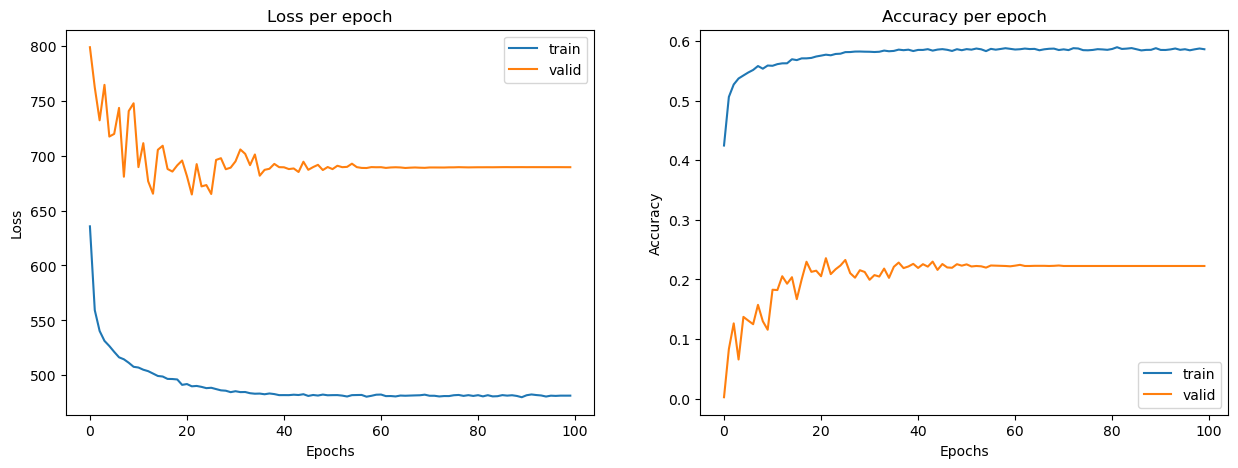

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 1s 353us/step
              precision    recall  f1-score   support

           0       0.68      0.83      0.75     46137
           1       0.12      0.65      0.21      3050
           2       0.31      0.46      0.37     17500
           3       0.74      0.22      0.34     45097

    accuracy                           0.52    111784
   macro avg       0.46      0.54      0.42    111784
weighted avg       0.63      0.52      0.51    111784
 




Classe prédite      0     1      2      3
Classe réelle                            
0               38174  2735   3308   1920
1                 245  1981    745     79
2                2080  5900   8010   1510
3               15580  5435  14036  10046



 Accuracy :  52.0


In [28]:
RandomNormal = tf.keras.initializers.RandomNormal(mean=0.0, stddev=1.0)
RandomUniform = tf.keras.initializers.RandomUniform(minval=0.0, maxval=1.0)
TruncatedNormal = tf.keras.initializers.TruncatedNormal(mean=0., stddev=1.)
GlorotNormal = tf.keras.initializers.GlorotNormal()
GlorotUniform = tf.keras.initializers.GlorotUniform()
HeNormal = tf.keras.initializers.HeNormal()
HeUniform = tf.keras.initializers.HeUniform()
Orthogonal = tf.keras.initializers.Orthogonal()
VarianceScaling_in = tf.keras.initializers.VarianceScaling(scale=1.0, mode="fan_in", distribution="truncated_normal")
VarianceScaling_out = tf.keras.initializers.VarianceScaling(scale=1.0, mode="fan_out", distribution="truncated_normal")
LecunNormal = tf.keras.initializers.LecunNormal()
LecunUniform = tf.keras.initializers.LecunUniform()

kernel_initializers = [RandomNormal, 
                       RandomUniform, 
                       TruncatedNormal,
                       GlorotNormal,
                       GlorotUniform,
                       HeNormal,
                       HeUniform,
                       Orthogonal, 
                       VarianceScaling_in, 
                       VarianceScaling_out, 
                       LecunNormal, 
                       LecunUniform]

for kernel_initializer in kernel_initializers :
    model4 = Sequential()
    model4.add( Dense(units = 70, activation = "swish", input_shape = (X_train.shape[1],), kernel_initializer = kernel_initializer))
    model4.add(Dense(units = 140, activation = "swish", kernel_initializer = kernel_initializer))
    model4.add(Dropout(rate = 0.2))
    model4.add( Dense(units = 70, activation = "swish", kernel_initializer = kernel_initializer))
    model4.add(Dense(units = 35, activation = "swish", kernel_initializer = kernel_initializer))
    model4.add(Dropout(rate = 0.2))
    model4.add(Dense(units = 14, activation = "swish", kernel_initializer = kernel_initializer))
    model4.add(Dense(units = 4, activation = 'softmax'))

    model4.compile(loss = loss,
               optimizer = "adam",
               metrics = ['sparse_categorical_accuracy'])
    
    history4 = model4.fit(X_train_ru, y_train_ru, epochs = 100, batch_size = 512, validation_split = 0.1, callbacks = [reduce_learning_rate])
    
    print("\n Modèle avec kernel_initializer :", kernel_initializer)
    
    plt.figure(figsize =(15, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history4.history['loss'], label = 'train')
    plt.plot(history4.history['val_loss'], label = 'valid')
    plt.xlabel("Epochs")
    plt.ylabel('Loss')
    plt.legend()
    plt.title("Loss per epoch")

    plt.subplot(1, 2, 2)
    plt.plot(history4.history['sparse_categorical_accuracy'], label = 'train')
    plt.plot(history4.history['val_sparse_categorical_accuracy'], label = 'valid')
    plt.xlabel("Epochs")
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title("Accuracy per epoch")

    plt.show()
    test_pred = model4.predict(X_test)
    test_pred_class = test_pred.argmax(axis=1)

    # Affichage des résultats
    print(classification_report(y_test, test_pred_class), '\n\n')

    display(pd.crosstab(y_test, test_pred_class, rownames = ['Classe réelle'], colnames = ['Classe prédite']))
    
    print('\n\n Accuracy : ', np.round(accuracy_score(y_test, test_pred_class), 2)*100)

Le meilleur kernel_initializer est VarianceScaling_in.

### Modèle 5 : choix du nombre de batch

In [29]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=False,
        ignore_class=None,
        reduction="sum",
        name="sparse_categorical_crossentropy",
    )

kernel_initializer = tf.keras.initializers.VarianceScaling(scale=1.0, mode="fan_in", distribution="truncated_normal")

Epoch 1/100


/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1030/1030 ━━━━━━━━━━━━━━━━━━━━ 2s 886us/step - loss: 37.9375 - sparse_categorical_accuracy: 0.4542 - val_loss: 49.2051 - val_sparse_categorical_accuracy: 0.0921 - learning_rate: 0.0010
Epoch 2/100
1030/1030 ━━━━━━━━━━━━━━━━━━━━ 1s 772us/step - loss: 33.5046 - sparse_categorical_accuracy: 0.5321 - val_loss: 52.2494 - val_sparse_categorical_accuracy: 0.0604 - learning_rate: 0.0010
Epoch 3/100
1030/1030 ━━━━━━━━━━━━━━━━━━━━ 1s 821us/step - loss: 32.7786 - sparse_categorical_accuracy: 0.5476 - val_loss: 46.8909 - val_sparse_categorical_accuracy: 0.1863 - learning_rate: 0.0010
Epoch 4/100
1030/1030 ━━━━━━━━━━━━━━━━━━━━ 1s 769us/step - loss: 32.1842 - sparse_categorical_accuracy: 0.5575 - val_loss: 46.3114 - val_sparse_categorical_accuracy: 0.1934 - learning_rate: 0.0010
Epoch 5/100
1030/1030 ━━━━━━━━━━━━━━━━━━━━ 1s 935us/step - loss: 31.7170 - sparse_categorical_accuracy: 0.5576 - val_loss: 51.1548 - val_sparse_categorical_accuracy: 0.1683 - learning_rate: 0.0010
Epoch 6/100
1030/1030 ━━━━━

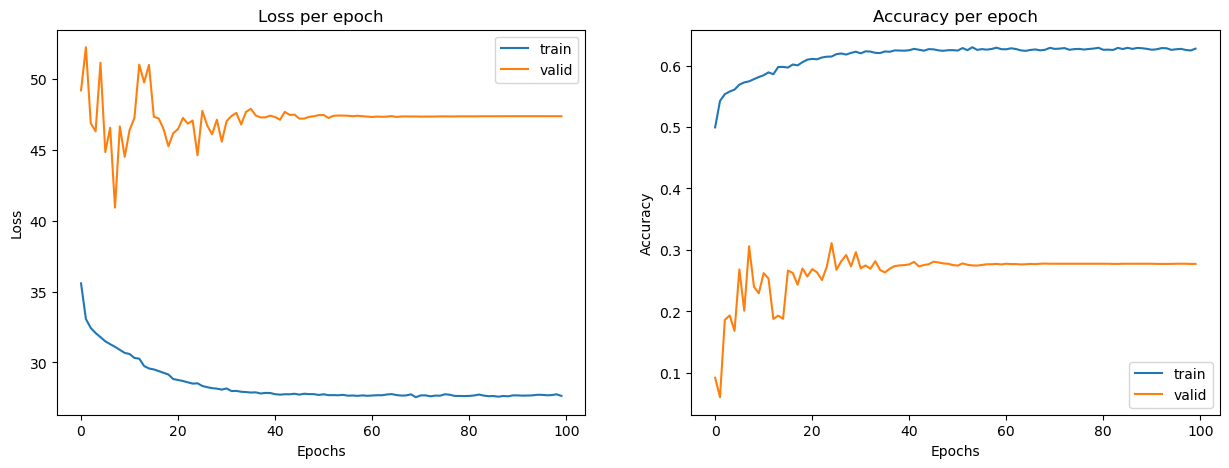

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 1s 350us/step
              precision    recall  f1-score   support

           0       0.70      0.81      0.75     46137
           1       0.12      0.63      0.21      3050
           2       0.32      0.46      0.37     17500
           3       0.72      0.28      0.40     45097

    accuracy                           0.53    111784
   macro avg       0.47      0.54      0.43    111784
weighted avg       0.63      0.53      0.53    111784
 




Classe prédite      0     1      2      3
Classe réelle                            
0               37367  2636   3324   2810
1                 209  1936    792    113
2                1862  5764   8031   1843
3               14026  5322  13326  12423



 Accuracy :  53.0
Epoch 1/100


/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 76.6490 - sparse_categorical_accuracy: 0.4497 - val_loss: 102.4939 - val_sparse_categorical_accuracy: 0.0806 - learning_rate: 0.0010
Epoch 2/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step - loss: 67.4995 - sparse_categorical_accuracy: 0.5353 - val_loss: 101.7588 - val_sparse_categorical_accuracy: 0.1276 - learning_rate: 0.0010
Epoch 3/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 960us/step - loss: 65.5104 - sparse_categorical_accuracy: 0.5506 - val_loss: 94.0901 - val_sparse_categorical_accuracy: 0.1969 - learning_rate: 0.0010
Epoch 4/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step - loss: 64.9729 - sparse_categorical_accuracy: 0.5569 - val_loss: 97.7351 - val_sparse_categorical_accuracy: 0.1557 - learning_rate: 0.0010
Epoch 5/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step - loss: 63.6625 - sparse_categorical_accuracy: 0.5618 - val_loss: 89.1401 - val_sparse_categorical_accuracy: 0.2611 - learning_rate: 0.0010
Epoch 6/100
515/515 ━━━━━━━━━━━━━━━━━

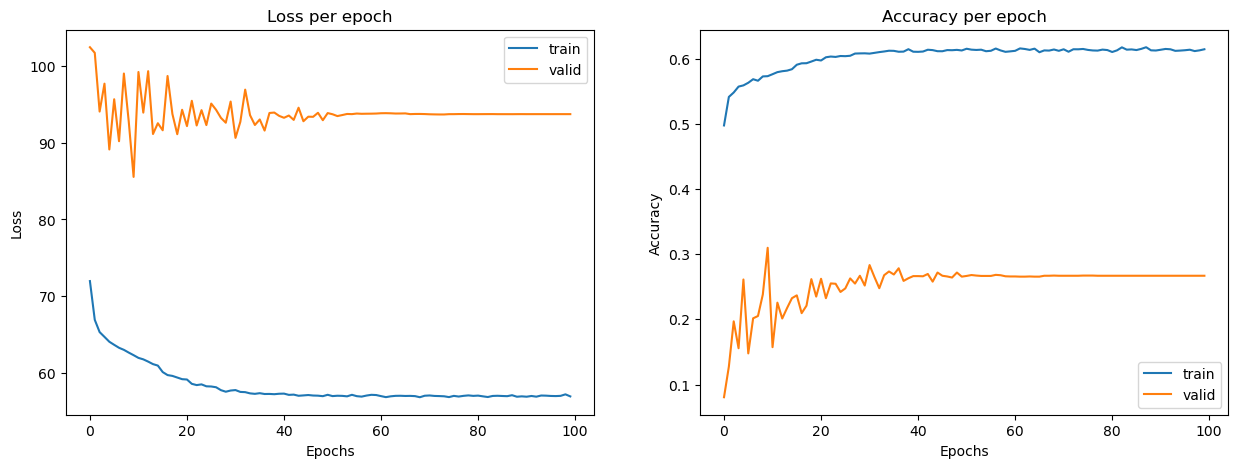

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 1s 361us/step
              precision    recall  f1-score   support

           0       0.69      0.82      0.75     46137
           1       0.13      0.65      0.21      3050
           2       0.32      0.46      0.38     17500
           3       0.74      0.27      0.39     45097

    accuracy                           0.54    111784
   macro avg       0.47      0.55      0.43    111784
weighted avg       0.64      0.54      0.53    111784
 




Classe prédite      0     1      2      3
Classe réelle                            
0               37934  2637   3179   2387
1                 206  1972    770    102
2                1912  5757   8036   1795
3               14659  5294  13053  12091



 Accuracy :  54.0
Epoch 1/100


/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 157.2883 - sparse_categorical_accuracy: 0.4356 - val_loss: 192.1360 - val_sparse_categorical_accuracy: 0.1328 - learning_rate: 0.0010
Epoch 2/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 135.0701 - sparse_categorical_accuracy: 0.5346 - val_loss: 223.9118 - val_sparse_categorical_accuracy: 0.0882 - learning_rate: 0.0010
Epoch 3/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 133.0034 - sparse_categorical_accuracy: 0.5393 - val_loss: 195.7738 - val_sparse_categorical_accuracy: 0.1765 - learning_rate: 0.0010
Epoch 4/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 130.2980 - sparse_categorical_accuracy: 0.5472 - val_loss: 197.0215 - val_sparse_categorical_accuracy: 0.1407 - learning_rate: 0.0010
Epoch 5/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 128.4605 - sparse_categorical_accuracy: 0.5608 - val_loss: 192.8285 - val_sparse_categorical_accuracy: 0.1694 - learning_rate: 0.0010
Epoch 6/100
221/258 ━━━━━━━━━━━━━━━━━

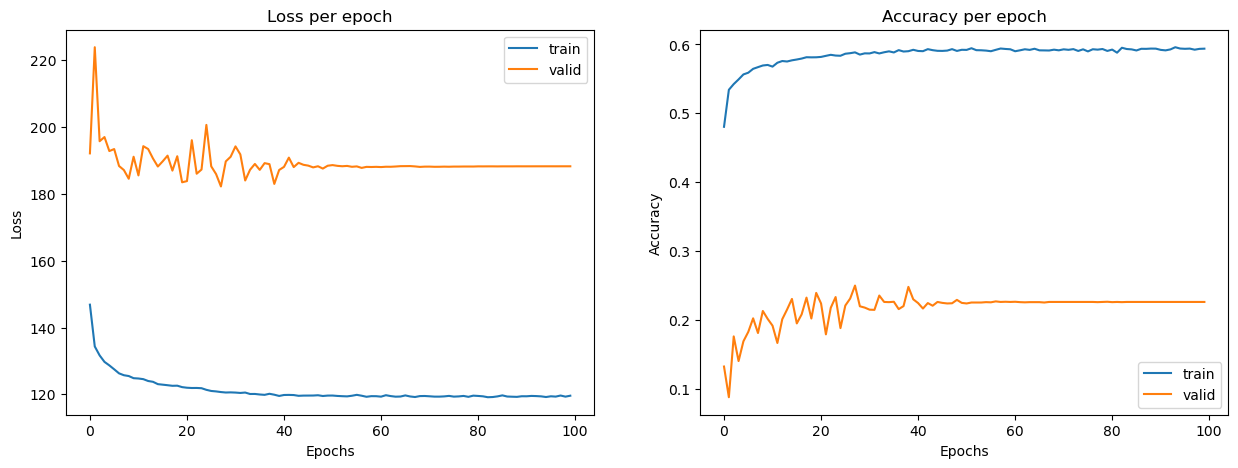

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 1s 356us/step
              precision    recall  f1-score   support

           0       0.69      0.83      0.75     46137
           1       0.13      0.65      0.21      3050
           2       0.31      0.46      0.37     17500
           3       0.74      0.24      0.36     45097

    accuracy                           0.53    111784
   macro avg       0.47      0.54      0.42    111784
weighted avg       0.64      0.53      0.52    111784
 




Classe prédite      0     1      2      3
Classe réelle                            
0               38183  2597   3366   1991
1                 224  1989    751     86
2                1947  5866   8123   1564
3               15150  5272  14049  10626



 Accuracy :  53.0
Epoch 1/100


/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 328.8656 - sparse_categorical_accuracy: 0.3889 - val_loss: 392.8571 - val_sparse_categorical_accuracy: 0.1134 - learning_rate: 0.0010
Epoch 2/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 278.6905 - sparse_categorical_accuracy: 0.5114 - val_loss: 419.1596 - val_sparse_categorical_accuracy: 0.1068 - learning_rate: 0.0010
Epoch 3/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 269.1448 - sparse_categorical_accuracy: 0.5371 - val_loss: 370.1710 - val_sparse_categorical_accuracy: 0.1549 - learning_rate: 0.0010
Epoch 4/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 263.6396 - sparse_categorical_accuracy: 0.5454 - val_loss: 392.4353 - val_sparse_categorical_accuracy: 0.1521 - learning_rate: 0.0010
Epoch 5/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 261.2246 - sparse_categorical_accuracy: 0.5477 - val_loss: 369.0569 - val_sparse_categorical_accuracy: 0.1322 - learning_rate: 0.0010
Epoch 6/100
129/129 ━━━━━━━━━━━━━━━━━

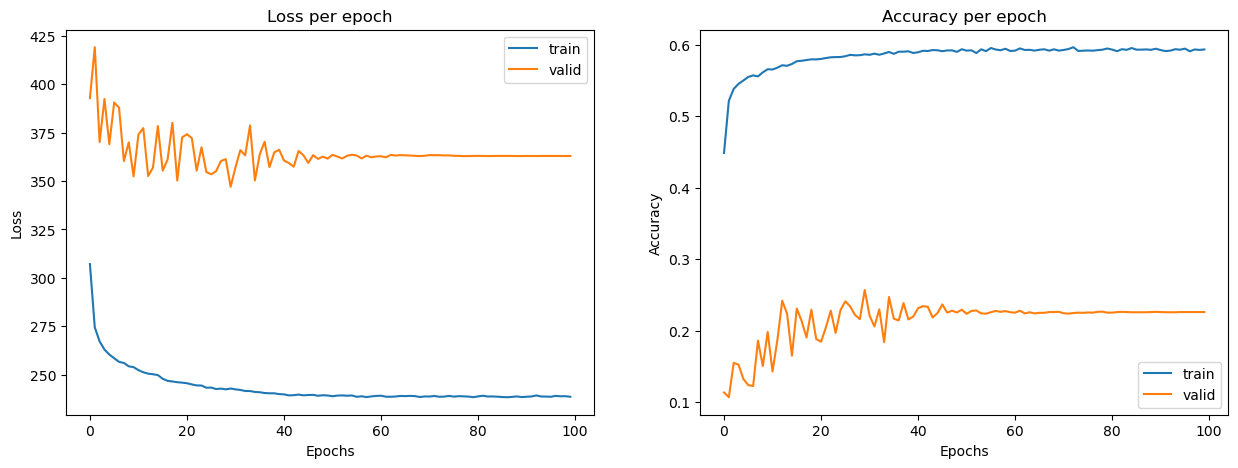

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 1s 361us/step
              precision    recall  f1-score   support

           0       0.68      0.83      0.75     46137
           1       0.13      0.65      0.21      3050
           2       0.31      0.47      0.37     17500
           3       0.75      0.23      0.36     45097

    accuracy                           0.53    111784
   macro avg       0.47      0.54      0.42    111784
weighted avg       0.64      0.53      0.52    111784
 




Classe prédite      0     1      2      3
Classe réelle                            
0               38250  2606   3285   1996
1                 220  1979    766     85
2                2048  5738   8185   1529
3               15366  5059  14106  10566



 Accuracy :  53.0
Epoch 1/100


/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 688.0219 - sparse_categorical_accuracy: 0.3404 - val_loss: 781.7355 - val_sparse_categorical_accuracy: 0.0104 - learning_rate: 0.0010
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 579.8396 - sparse_categorical_accuracy: 0.4965 - val_loss: 769.9611 - val_sparse_categorical_accuracy: 0.0554 - learning_rate: 0.0010
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 548.5038 - sparse_categorical_accuracy: 0.5280 - val_loss: 711.4608 - val_sparse_categorical_accuracy: 0.1322 - learning_rate: 0.0010
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 537.5862 - sparse_categorical_accuracy: 0.5377 - val_loss: 747.7137 - val_sparse_categorical_accuracy: 0.1093 - learning_rate: 0.0010
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 528.7657 - sparse_categorical_accuracy: 0.5442 - val_loss: 696.1559 - val_sparse_categorical_accuracy: 0.1628 - learning_rate: 0.0010
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/s

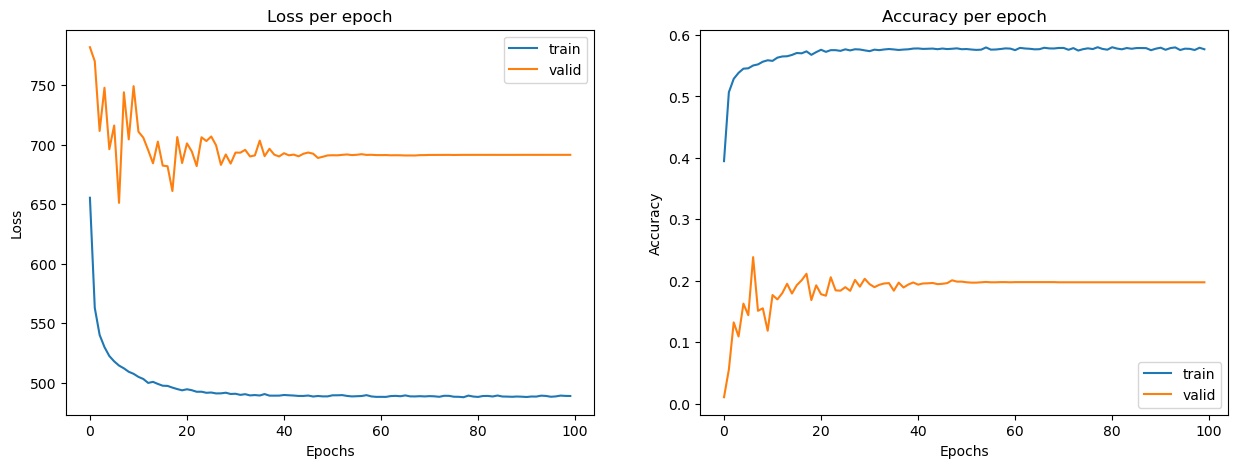

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 1s 361us/step
              precision    recall  f1-score   support

           0       0.68      0.83      0.75     46137
           1       0.13      0.66      0.21      3050
           2       0.30      0.45      0.36     17500
           3       0.73      0.21      0.32     45097

    accuracy                           0.51    111784
   macro avg       0.46      0.54      0.41    111784
weighted avg       0.63      0.51      0.50    111784
 




Classe prédite      0     1      2     3
Classe réelle                           
0               38261  2728   3269  1879
1                 249  2001    725    75
2                2130  5953   7960  1457
3               15795  5242  14726  9334



 Accuracy :  51.0
Epoch 1/100


/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1398.4104 - sparse_categorical_accuracy: 0.2983 - val_loss: 1652.4410 - val_sparse_categorical_accuracy: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1235.8792 - sparse_categorical_accuracy: 0.4484 - val_loss: 1480.3026 - val_sparse_categorical_accuracy: 0.0653 - learning_rate: 0.0010
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1128.6616 - sparse_categorical_accuracy: 0.5045 - val_loss: 1575.3040 - val_sparse_categorical_accuracy: 0.0508 - learning_rate: 0.0010
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1091.5547 - sparse_categorical_accuracy: 0.5241 - val_loss: 1438.7181 - val_sparse_categorical_accuracy: 0.1459 - learning_rate: 0.0010
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1077.2522 - sparse_categorical_accuracy: 0.5317 - val_loss: 1420.0579 - val_sparse_categorical_accuracy: 0.1562 - learning_rate: 0.0010
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━

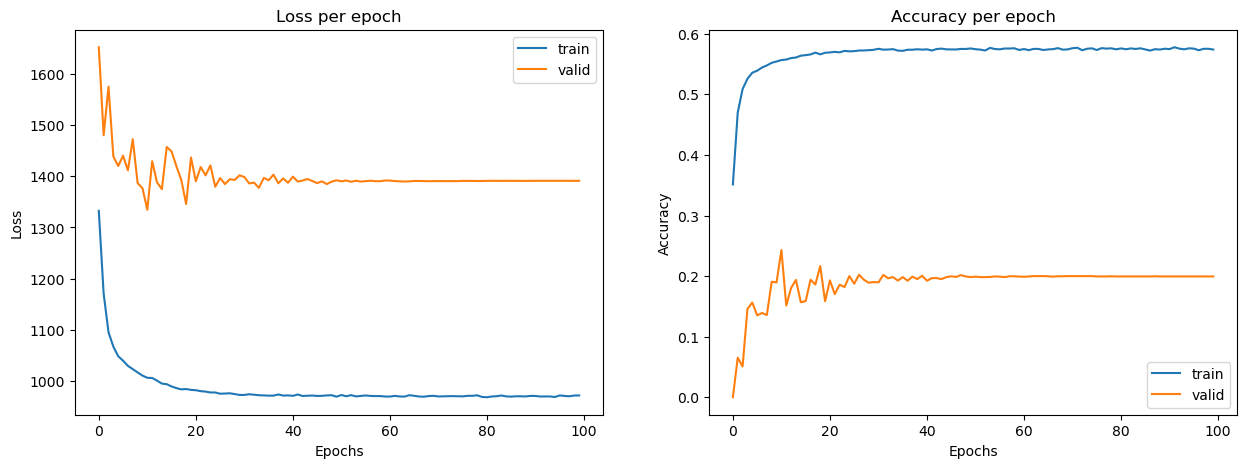

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 1s 339us/step
              precision    recall  f1-score   support

           0       0.68      0.82      0.74     46137
           1       0.12      0.67      0.21      3050
           2       0.30      0.45      0.36     17500
           3       0.73      0.21      0.32     45097

    accuracy                           0.51    111784
   macro avg       0.46      0.54      0.41    111784
weighted avg       0.62      0.51      0.50    111784
 




Classe prédite      0     1      2     3
Classe réelle                           
0               37875  2973   3208  2081
1                 249  2029    702    70
2                2141  6097   7880  1382
3               15640  5536  14592  9329



 Accuracy :  51.0
Epoch 1/100


/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 2781.9856 - sparse_categorical_accuracy: 0.3211 - val_loss: 3340.3657 - val_sparse_categorical_accuracy: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2580.8276 - sparse_categorical_accuracy: 0.4144 - val_loss: 3242.0393 - val_sparse_categorical_accuracy: 0.0014 - learning_rate: 0.0010
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2387.8472 - sparse_categorical_accuracy: 0.4687 - val_loss: 3135.5825 - val_sparse_categorical_accuracy: 0.0541 - learning_rate: 0.0010
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2294.7766 - sparse_categorical_accuracy: 0.4931 - val_loss: 3102.4575 - val_sparse_categorical_accuracy: 0.0915 - learning_rate: 0.0010
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2240.7607 - sparse_categorical_accuracy: 0.5092 - val_loss: 2993.6189 - val_sparse_categorical_accuracy: 0.1243 - learning_rate: 0.0010
Epoch 6/100
17/17 ━━━━━━━━━━━━━━

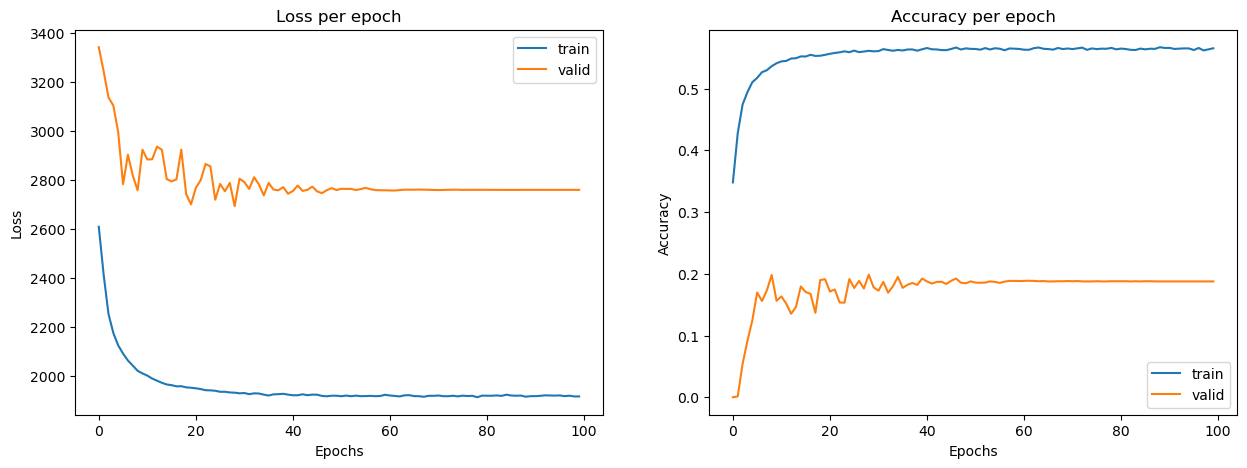

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 1s 360us/step
              precision    recall  f1-score   support

           0       0.67      0.82      0.74     46137
           1       0.12      0.64      0.21      3050
           2       0.29      0.47      0.36     17500
           3       0.73      0.19      0.31     45097

    accuracy                           0.51    111784
   macro avg       0.45      0.53      0.40    111784
weighted avg       0.62      0.51      0.49    111784
 




Classe prédite      0     1      2     3
Classe réelle                           
0               37676  2858   3743  1860
1                 252  1940    791    67
2                2168  5728   8259  1345
3               15824  5120  15416  8737



 Accuracy :  51.0


In [30]:
batchs = [32, 64, 128, 256, 512, 1024, 2048]

for batch in batchs :
    model5 = Sequential()
    model5.add( Dense(units = 70, activation = "swish", input_shape = (X_train.shape[1],), kernel_initializer = kernel_initializer))
    model5.add(Dense(units = 140, activation = "swish", kernel_initializer = kernel_initializer))
    model5.add(Dropout(rate = 0.2))
    model5.add( Dense(units = 70, activation = "swish", kernel_initializer = kernel_initializer))
    model5.add(Dense(units = 35, activation = "swish", kernel_initializer = kernel_initializer))
    model5.add(Dropout(rate = 0.2))
    model5.add(Dense(units = 14, activation = "swish", kernel_initializer = kernel_initializer))
    model5.add(Dense(units = 4, activation = 'softmax'))

    model5.compile(loss = loss,
               optimizer = "adam",
               metrics = ['sparse_categorical_accuracy'])
    
    history5 = model5.fit(X_train_ru, y_train_ru, epochs = 100, batch_size = batch, validation_split = 0.1, callbacks = [reduce_learning_rate])
    
    print("\n Modèle avec batch_size de :", batch)
    
    plt.figure(figsize =(15, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history5.history['loss'], label = 'train')
    plt.plot(history5.history['val_loss'], label = 'valid')
    plt.xlabel("Epochs")
    plt.ylabel('Loss')
    plt.legend()
    plt.title("Loss per epoch")

    plt.subplot(1, 2, 2)
    plt.plot(history5.history['sparse_categorical_accuracy'], label = 'train')
    plt.plot(history5.history['val_sparse_categorical_accuracy'], label = 'valid')
    plt.xlabel("Epochs")
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title("Accuracy per epoch")

    plt.show()
    test_pred = model5.predict(X_test)
    test_pred_class = test_pred.argmax(axis=1)

    # Affichage des résultats
    print(classification_report(y_test, test_pred_class), '\n\n')

    display(pd.crosstab(y_test, test_pred_class, rownames = ['Classe réelle'], colnames = ['Classe prédite']))
    
    print('\n\n Accuracy : ', np.round(accuracy_score(y_test, test_pred_class), 2)*100)

Il y a toujours une surapprentissage quelque soit la taille du batch.
On chosi donc la taille de batch qui permet d'obtenir le meilleurs résultats : 128.

### Modèle 6 : choix du nombre d'epochs

In [31]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=False,
        ignore_class=None,
        reduction="sum",
        name="sparse_categorical_crossentropy",
    )

kernel_initializer = tf.keras.initializers.VarianceScaling(scale=1.0, mode="fan_in", distribution="truncated_normal")

Epoch 1/10


/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 77.9126 - sparse_categorical_accuracy: 0.4374 - val_loss: 100.3475 - val_sparse_categorical_accuracy: 0.0890 - learning_rate: 0.0010
Epoch 2/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step - loss: 67.3104 - sparse_categorical_accuracy: 0.5342 - val_loss: 93.5987 - val_sparse_categorical_accuracy: 0.2051 - learning_rate: 0.0010
Epoch 3/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 65.8890 - sparse_categorical_accuracy: 0.5479 - val_loss: 99.3398 - val_sparse_categorical_accuracy: 0.1401 - learning_rate: 0.0010
Epoch 4/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step - loss: 65.1262 - sparse_categorical_accuracy: 0.5489 - val_loss: 102.1381 - val_sparse_categorical_accuracy: 0.0964 - learning_rate: 0.0010
Epoch 5/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step - loss: 64.5402 - sparse_categorical_accuracy: 0.5542 - val_loss: 100.9539 - val_sparse_categorical_accuracy: 0.1918 - learning_rate: 0.0010
Epoch 6/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s

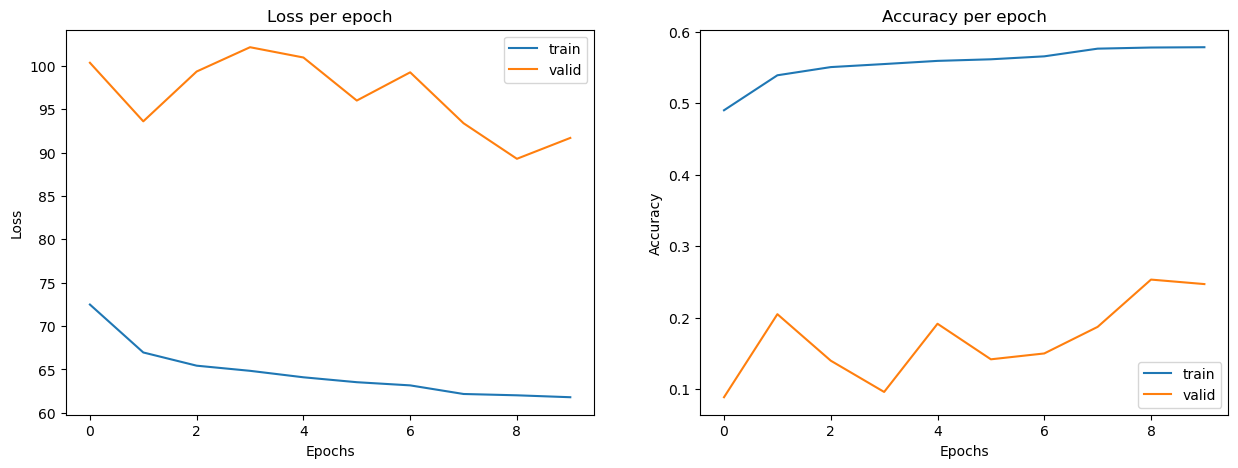

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 1s 392us/step
              precision    recall  f1-score   support

           0       0.68      0.83      0.75     46137
           1       0.12      0.67      0.21      3050
           2       0.31      0.43      0.36     17500
           3       0.76      0.25      0.37     45097

    accuracy                           0.53    111784
   macro avg       0.47      0.55      0.42    111784
weighted avg       0.64      0.53      0.52    111784
 




Classe prédite      0     1      2      3
Classe réelle                            
0               38374  2921   3140   1702
1                 225  2048    680     97
2                1975  6175   7530   1820
3               15590  5649  12663  11195



 Accuracy :  53.0
Epoch 1/20


/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 77.7183 - sparse_categorical_accuracy: 0.4371 - val_loss: 100.6372 - val_sparse_categorical_accuracy: 0.1161 - learning_rate: 0.0010
Epoch 2/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step - loss: 67.5376 - sparse_categorical_accuracy: 0.5316 - val_loss: 85.0206 - val_sparse_categorical_accuracy: 0.2587 - learning_rate: 0.0010
Epoch 3/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 917us/step - loss: 65.9290 - sparse_categorical_accuracy: 0.5440 - val_loss: 100.0549 - val_sparse_categorical_accuracy: 0.1374 - learning_rate: 0.0010
Epoch 4/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step - loss: 65.1637 - sparse_categorical_accuracy: 0.5520 - val_loss: 100.2199 - val_sparse_categorical_accuracy: 0.1461 - learning_rate: 0.0010
Epoch 5/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 961us/step - loss: 64.5497 - sparse_categorical_accuracy: 0.5581 - val_loss: 97.5966 - val_sparse_categorical_accuracy: 0.2204 - learning_rate: 0.0010
Epoch 6/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 

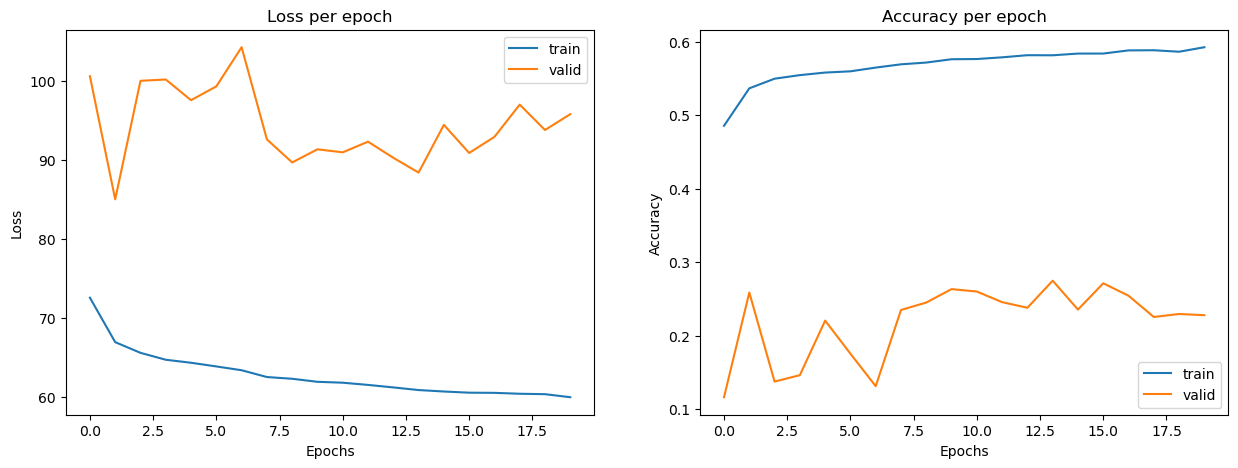

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 1s 369us/step
              precision    recall  f1-score   support

           0       0.69      0.82      0.75     46137
           1       0.12      0.66      0.21      3050
           2       0.31      0.47      0.37     17500
           3       0.74      0.23      0.35     45097

    accuracy                           0.52    111784
   macro avg       0.47      0.54      0.42    111784
weighted avg       0.64      0.52      0.51    111784
 




Classe prédite      0     1      2      3
Classe réelle                            
0               37766  2964   3330   2077
1                 208  2008    758     76
2                1816  5965   8254   1465
3               14620  5550  14660  10267



 Accuracy :  52.0
Epoch 1/30


/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


515/515 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 77.2869 - sparse_categorical_accuracy: 0.4458 - val_loss: 95.7289 - val_sparse_categorical_accuracy: 0.1825 - learning_rate: 0.0010
Epoch 2/30
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 952us/step - loss: 67.1128 - sparse_categorical_accuracy: 0.5343 - val_loss: 95.8845 - val_sparse_categorical_accuracy: 0.1909 - learning_rate: 0.0010
Epoch 3/30
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step - loss: 66.2072 - sparse_categorical_accuracy: 0.5412 - val_loss: 100.6566 - val_sparse_categorical_accuracy: 0.1642 - learning_rate: 0.0010
Epoch 4/30
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step - loss: 65.1688 - sparse_categorical_accuracy: 0.5493 - val_loss: 105.0334 - val_sparse_categorical_accuracy: 0.1262 - learning_rate: 0.0010
Epoch 5/30
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step - loss: 64.3906 - sparse_categorical_accuracy: 0.5554 - val_loss: 97.0711 - val_sparse_categorical_accuracy: 0.1404 - learning_rate: 0.0010
Epoch 6/30
501/515 ━━━━━━━━━━━━━━━━━━━━ 0

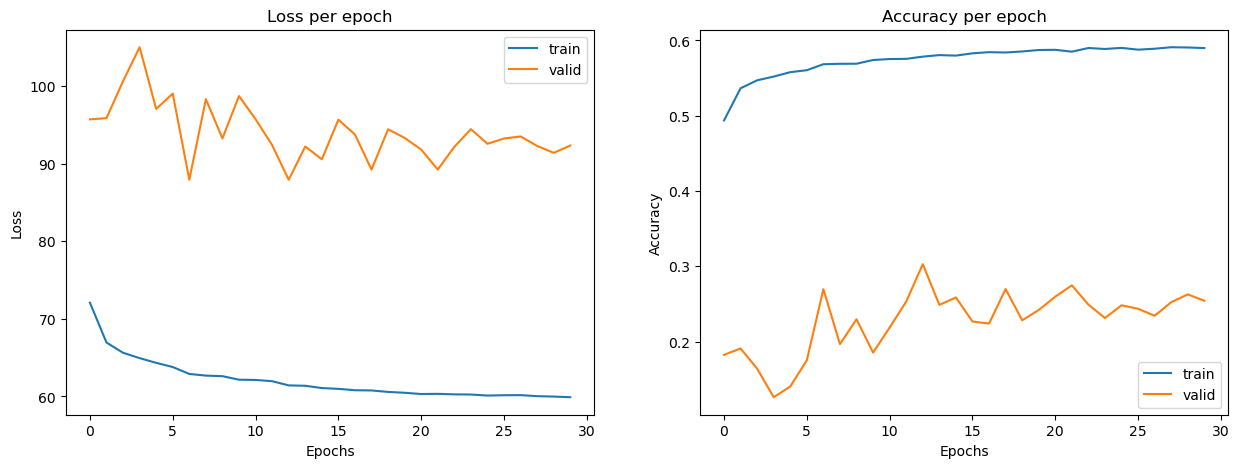

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 1s 372us/step
              precision    recall  f1-score   support

           0       0.69      0.83      0.75     46137
           1       0.13      0.64      0.21      3050
           2       0.32      0.46      0.38     17500
           3       0.73      0.26      0.39     45097

    accuracy                           0.54    111784
   macro avg       0.47      0.55      0.43    111784
weighted avg       0.64      0.54      0.53    111784
 




Classe prédite      0     1      2      3
Classe réelle                            
0               38101  2536   3112   2388
1                 230  1961    759    100
2                1964  5677   8084   1775
3               14744  5182  13380  11791



 Accuracy :  54.0
Epoch 1/40


/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 77.5744 - sparse_categorical_accuracy: 0.4349 - val_loss: 103.8712 - val_sparse_categorical_accuracy: 0.1276 - learning_rate: 0.0010
Epoch 2/40
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 998us/step - loss: 67.1283 - sparse_categorical_accuracy: 0.5350 - val_loss: 95.3922 - val_sparse_categorical_accuracy: 0.1352 - learning_rate: 0.0010
Epoch 3/40
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 979us/step - loss: 65.6921 - sparse_categorical_accuracy: 0.5480 - val_loss: 101.3569 - val_sparse_categorical_accuracy: 0.0904 - learning_rate: 0.0010
Epoch 4/40
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step - loss: 65.3048 - sparse_categorical_accuracy: 0.5501 - val_loss: 94.2529 - val_sparse_categorical_accuracy: 0.2559 - learning_rate: 0.0010
Epoch 5/40
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 974us/step - loss: 63.7964 - sparse_categorical_accuracy: 0.5651 - val_loss: 99.0333 - val_sparse_categorical_accuracy: 0.1445 - learning_rate: 0.0010
Epoch 6/40
515/515 ━━━━━━━━━━━━━━━━━━━━ 0

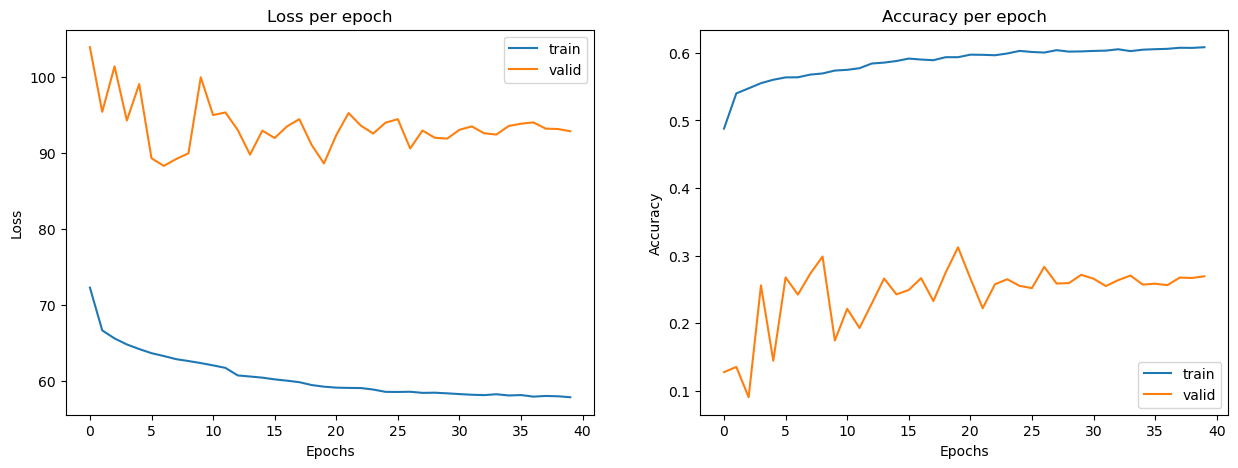

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 1s 396us/step
              precision    recall  f1-score   support

           0       0.70      0.82      0.75     46137
           1       0.13      0.63      0.21      3050
           2       0.32      0.48      0.38     17500
           3       0.74      0.26      0.39     45097

    accuracy                           0.54    111784
   macro avg       0.47      0.55      0.44    111784
weighted avg       0.64      0.54      0.53    111784
 




Classe prédite      0     1      2      3
Classe réelle                            
0               37968  2464   3243   2462
1                 220  1913    811    106
2                1928  5504   8339   1729
3               14503  4896  13749  11949



 Accuracy :  54.0
Epoch 1/50


/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 77.7088 - sparse_categorical_accuracy: 0.4318 - val_loss: 103.6651 - val_sparse_categorical_accuracy: 0.0874 - learning_rate: 0.0010
Epoch 2/50
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 944us/step - loss: 67.3977 - sparse_categorical_accuracy: 0.5323 - val_loss: 94.4709 - val_sparse_categorical_accuracy: 0.1297 - learning_rate: 0.0010
Epoch 3/50
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step - loss: 65.4779 - sparse_categorical_accuracy: 0.5504 - val_loss: 103.6783 - val_sparse_categorical_accuracy: 0.0972 - learning_rate: 0.0010
Epoch 4/50
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 874us/step - loss: 64.7163 - sparse_categorical_accuracy: 0.5532 - val_loss: 101.3874 - val_sparse_categorical_accuracy: 0.0992 - learning_rate: 0.0010
Epoch 5/50
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 961us/step - loss: 63.6983 - sparse_categorical_accuracy: 0.5602 - val_loss: 94.7593 - val_sparse_categorical_accuracy: 0.1969 - learning_rate: 0.0010
Epoch 6/50
515/515 ━━━━━━━━━━━━━━━━━━━━ 

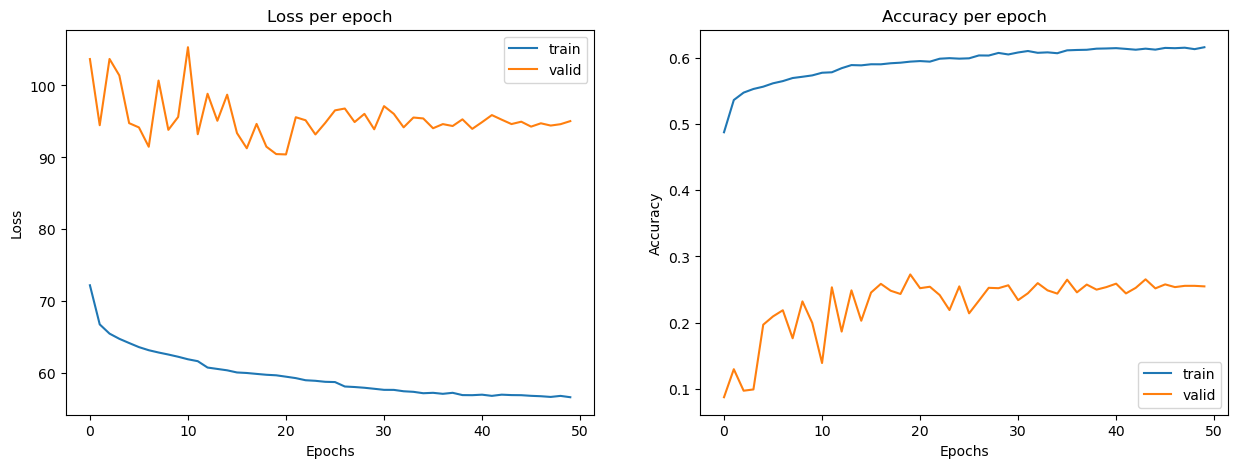

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 1s 316us/step
              precision    recall  f1-score   support

           0       0.70      0.81      0.75     46137
           1       0.12      0.63      0.21      3050
           2       0.32      0.48      0.38     17500
           3       0.72      0.26      0.38     45097

    accuracy                           0.53    111784
   macro avg       0.47      0.55      0.43    111784
weighted avg       0.63      0.53      0.53    111784
 




Classe prédite      0     1      2      3
Classe réelle                            
0               37581  2588   3311   2657
1                 200  1921    822    107
2                1806  5602   8373   1719
3               14021  5306  13953  11817



 Accuracy :  53.0
Epoch 1/60


/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 77.8419 - sparse_categorical_accuracy: 0.4330 - val_loss: 95.6249 - val_sparse_categorical_accuracy: 0.1912 - learning_rate: 0.0010
Epoch 2/60
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step - loss: 67.3320 - sparse_categorical_accuracy: 0.5336 - val_loss: 99.9708 - val_sparse_categorical_accuracy: 0.1475 - learning_rate: 0.0010
Epoch 3/60
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step - loss: 66.1619 - sparse_categorical_accuracy: 0.5431 - val_loss: 87.2348 - val_sparse_categorical_accuracy: 0.2712 - learning_rate: 0.0010
Epoch 4/60
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step - loss: 64.8730 - sparse_categorical_accuracy: 0.5539 - val_loss: 91.5254 - val_sparse_categorical_accuracy: 0.2426 - learning_rate: 0.0010
Epoch 5/60
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step - loss: 64.6142 - sparse_categorical_accuracy: 0.5577 - val_loss: 96.2085 - val_sparse_categorical_accuracy: 0.1699 - learning_rate: 0.0010
Epoch 6/60
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 

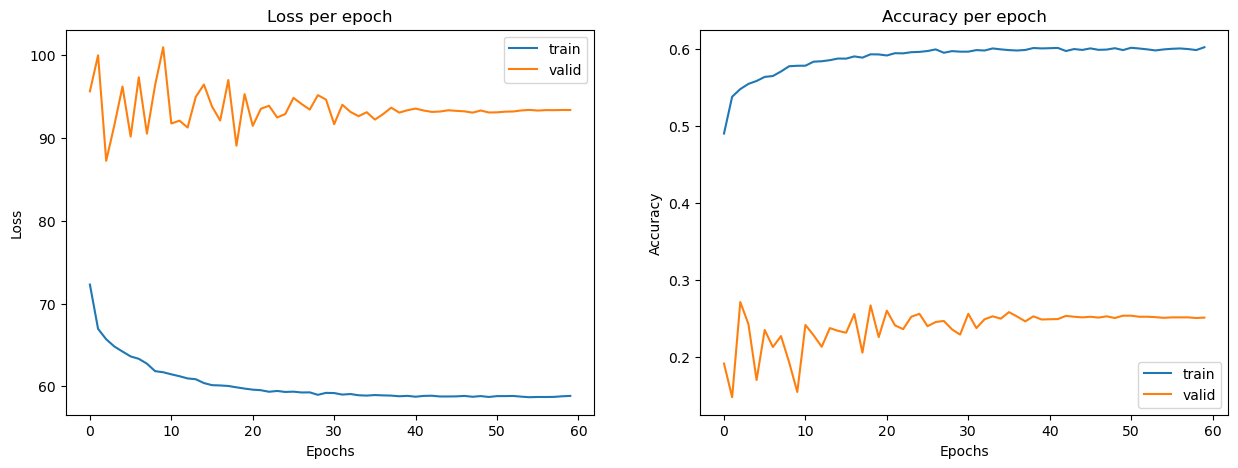

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 1s 314us/step
              precision    recall  f1-score   support

           0       0.69      0.82      0.75     46137
           1       0.13      0.64      0.21      3050
           2       0.31      0.46      0.37     17500
           3       0.74      0.26      0.38     45097

    accuracy                           0.53    111784
   macro avg       0.47      0.55      0.43    111784
weighted avg       0.64      0.53      0.53    111784
 




Classe prédite      0     1      2      3
Classe réelle                            
0               38040  2533   3271   2293
1                 207  1957    791     95
2                1909  5783   8120   1688
3               14603  5222  13686  11586



 Accuracy :  53.0
Epoch 1/70


/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 77.5892 - sparse_categorical_accuracy: 0.4351 - val_loss: 113.0806 - val_sparse_categorical_accuracy: 0.0530 - learning_rate: 0.0010
Epoch 2/70
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step - loss: 67.7710 - sparse_categorical_accuracy: 0.5259 - val_loss: 91.7498 - val_sparse_categorical_accuracy: 0.1844 - learning_rate: 0.0010
Epoch 3/70
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step - loss: 65.1833 - sparse_categorical_accuracy: 0.5497 - val_loss: 98.5527 - val_sparse_categorical_accuracy: 0.1609 - learning_rate: 0.0010
Epoch 4/70
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step - loss: 65.0060 - sparse_categorical_accuracy: 0.5480 - val_loss: 100.3036 - val_sparse_categorical_accuracy: 0.1590 - learning_rate: 0.0010
Epoch 5/70
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step - loss: 64.3324 - sparse_categorical_accuracy: 0.5580 - val_loss: 89.9362 - val_sparse_categorical_accuracy: 0.2346 - learning_rate: 0.0010
Epoch 6/70
515/515 ━━━━━━━━━━━━━━━━━━━━ 0

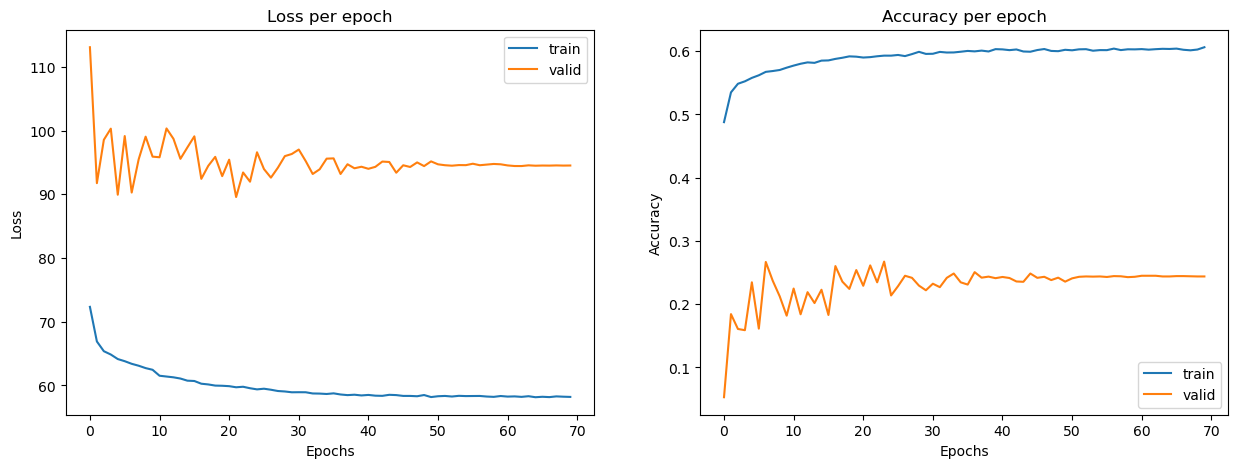

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 1s 322us/step
              precision    recall  f1-score   support

           0       0.70      0.82      0.75     46137
           1       0.13      0.64      0.21      3050
           2       0.32      0.48      0.38     17500
           3       0.73      0.25      0.38     45097

    accuracy                           0.53    111784
   macro avg       0.47      0.55      0.43    111784
weighted avg       0.64      0.53      0.53    111784
 




Classe prédite      0     1      2      3
Classe réelle                            
0               37685  2703   3329   2420
1                 205  1952    790    103
2                1905  5615   8349   1631
3               14391  5246  14007  11453



 Accuracy :  53.0
Epoch 1/80


/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 78.1374 - sparse_categorical_accuracy: 0.4280 - val_loss: 98.6991 - val_sparse_categorical_accuracy: 0.1549 - learning_rate: 0.0010
Epoch 2/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 907us/step - loss: 67.1687 - sparse_categorical_accuracy: 0.5383 - val_loss: 105.6088 - val_sparse_categorical_accuracy: 0.0688 - learning_rate: 0.0010
Epoch 3/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step - loss: 65.4724 - sparse_categorical_accuracy: 0.5487 - val_loss: 104.1272 - val_sparse_categorical_accuracy: 0.1546 - learning_rate: 0.0010
Epoch 4/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 890us/step - loss: 65.0029 - sparse_categorical_accuracy: 0.5521 - val_loss: 96.9276 - val_sparse_categorical_accuracy: 0.2193 - learning_rate: 0.0010
Epoch 5/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step - loss: 64.4895 - sparse_categorical_accuracy: 0.5532 - val_loss: 96.4595 - val_sparse_categorical_accuracy: 0.1579 - learning_rate: 0.0010
Epoch 6/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 0

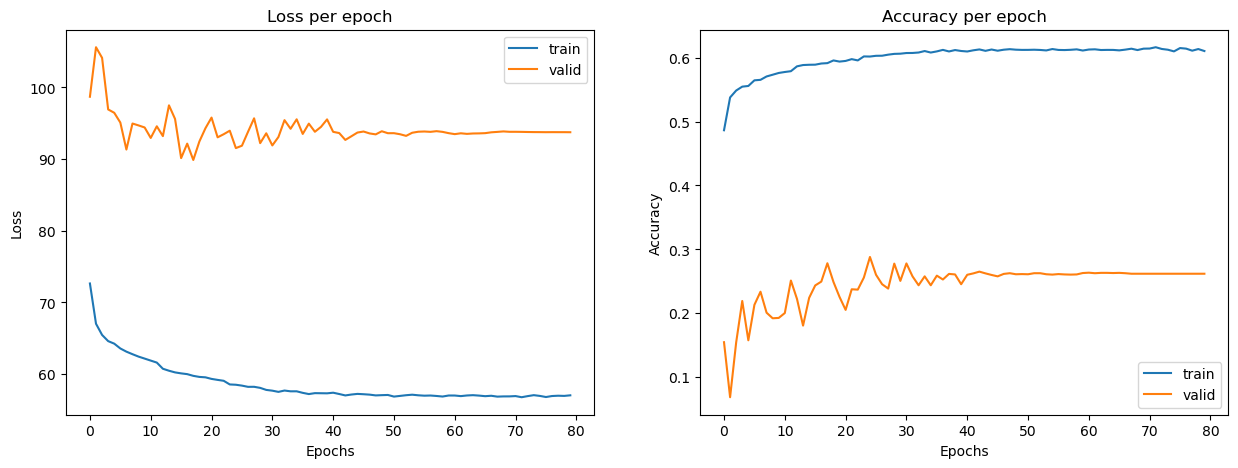

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 1s 327us/step
              precision    recall  f1-score   support

           0       0.70      0.82      0.76     46137
           1       0.13      0.64      0.21      3050
           2       0.32      0.47      0.38     17500
           3       0.73      0.26      0.39     45097

    accuracy                           0.54    111784
   macro avg       0.47      0.55      0.43    111784
weighted avg       0.64      0.54      0.53    111784
 




Classe prédite      0     1      2      3
Classe réelle                            
0               37991  2488   3240   2418
1                 208  1945    800     97
2                1871  5661   8179   1789
3               14328  5256  13719  11794



 Accuracy :  54.0
Epoch 1/90


/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 77.8115 - sparse_categorical_accuracy: 0.4336 - val_loss: 104.6523 - val_sparse_categorical_accuracy: 0.1109 - learning_rate: 0.0010
Epoch 2/90
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step - loss: 67.1221 - sparse_categorical_accuracy: 0.5345 - val_loss: 96.7696 - val_sparse_categorical_accuracy: 0.1773 - learning_rate: 0.0010
Epoch 3/90
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step - loss: 66.0577 - sparse_categorical_accuracy: 0.5480 - val_loss: 91.7173 - val_sparse_categorical_accuracy: 0.2008 - learning_rate: 0.0010
Epoch 4/90
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 989us/step - loss: 65.1423 - sparse_categorical_accuracy: 0.5521 - val_loss: 96.1154 - val_sparse_categorical_accuracy: 0.1511 - learning_rate: 0.0010
Epoch 5/90
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 993us/step - loss: 64.1176 - sparse_categorical_accuracy: 0.5570 - val_loss: 90.0651 - val_sparse_categorical_accuracy: 0.2529 - learning_rate: 0.0010
Epoch 6/90
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s

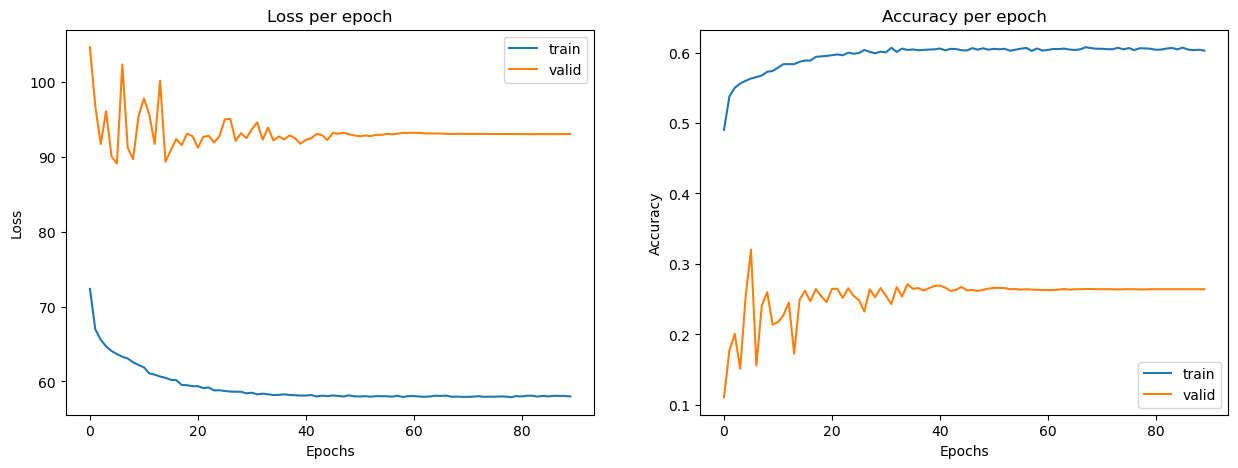

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 1s 335us/step
              precision    recall  f1-score   support

           0       0.69      0.82      0.75     46137
           1       0.13      0.64      0.21      3050
           2       0.32      0.47      0.38     17500
           3       0.74      0.26      0.38     45097

    accuracy                           0.54    111784
   macro avg       0.47      0.55      0.43    111784
weighted avg       0.64      0.54      0.53    111784
 




Classe prédite      0     1      2      3
Classe réelle                            
0               38022  2621   3247   2247
1                 209  1963    792     86
2                1875  5696   8186   1743
3               14604  5163  13608  11722



 Accuracy :  54.0
Epoch 1/100


/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


515/515 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 77.2461 - sparse_categorical_accuracy: 0.4437 - val_loss: 92.6913 - val_sparse_categorical_accuracy: 0.2051 - learning_rate: 0.0010
Epoch 2/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 908us/step - loss: 66.9141 - sparse_categorical_accuracy: 0.5380 - val_loss: 92.8488 - val_sparse_categorical_accuracy: 0.2264 - learning_rate: 0.0010
Epoch 3/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 960us/step - loss: 65.6776 - sparse_categorical_accuracy: 0.5486 - val_loss: 92.8374 - val_sparse_categorical_accuracy: 0.1849 - learning_rate: 0.0010
Epoch 4/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step - loss: 64.7484 - sparse_categorical_accuracy: 0.5566 - val_loss: 90.7304 - val_sparse_categorical_accuracy: 0.2207 - learning_rate: 0.0010
Epoch 5/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step - loss: 64.0083 - sparse_categorical_accuracy: 0.5588 - val_loss: 92.9946 - val_sparse_categorical_accuracy: 0.2245 - learning_rate: 0.0010
Epoch 6/100
515/515 ━━━━━━━━━━━━━━━━━━━

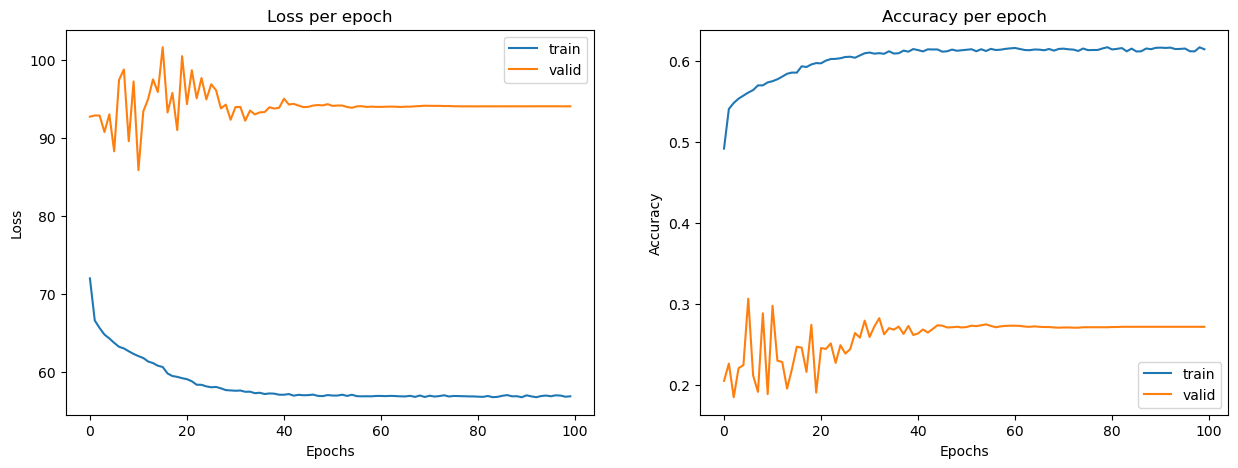

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 1s 329us/step
              precision    recall  f1-score   support

           0       0.70      0.81      0.75     46137
           1       0.12      0.64      0.21      3050
           2       0.32      0.46      0.38     17500
           3       0.73      0.27      0.39     45097

    accuracy                           0.54    111784
   macro avg       0.47      0.55      0.43    111784
weighted avg       0.64      0.54      0.53    111784
 




Classe prédite      0     1      2      3
Classe réelle                            
0               37566  2639   3301   2631
1                 191  1950    807    102
2                1825  5731   8123   1821
3               14076  5347  13493  12181



 Accuracy :  54.0


In [32]:
epochs = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

for epoch in epochs :
    model6 = Sequential()
    model6.add( Dense(units = 70, activation = "swish", input_shape = (X_train.shape[1],), kernel_initializer = kernel_initializer))
    model6.add(Dense(units = 140, activation = "swish", kernel_initializer = kernel_initializer))
    model6.add(Dropout(rate = 0.2))
    model6.add( Dense(units = 70, activation = "swish", kernel_initializer = kernel_initializer))
    model6.add(Dense(units = 35, activation = "swish", kernel_initializer = kernel_initializer))
    model6.add(Dropout(rate = 0.2))
    model6.add(Dense(units = 14, activation = "swish", kernel_initializer = kernel_initializer))
    model6.add(Dense(units = 4, activation = 'softmax'))

    model6.compile(loss = loss,
               optimizer = "adam",
               metrics = ['sparse_categorical_accuracy'])
    
    history6 = model6.fit(X_train_ru, y_train_ru, epochs = epoch, batch_size = 64, validation_split = 0.1, callbacks = [reduce_learning_rate])
    
    print("\n Modèle avec une epoch de :", epoch)
    
    plt.figure(figsize =(15, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history6.history['loss'], label = 'train')
    plt.plot(history6.history['val_loss'], label = 'valid')
    plt.xlabel("Epochs")
    plt.ylabel('Loss')
    plt.legend()
    plt.title("Loss per epoch")

    plt.subplot(1, 2, 2)
    plt.plot(history6.history['sparse_categorical_accuracy'], label = 'train')
    plt.plot(history6.history['val_sparse_categorical_accuracy'], label = 'valid')
    plt.xlabel("Epochs")
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title("Accuracy per epoch")

    plt.show()
    test_pred = model6.predict(X_test)
    test_pred_class = test_pred.argmax(axis=1)

    # Affichage des résultats
    print(classification_report(y_test, test_pred_class), '\n\n')

    display(pd.crosstab(y_test, test_pred_class, rownames = ['Classe réelle'], colnames = ['Classe prédite']))
    
    print('\n\n Accuracy : ', np.round(accuracy_score(y_test, test_pred_class), 2)*100)

Le meilleur nombre d'epochs semble être 40.

# Meilleur modèle

In [21]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=False,
        ignore_class=None,
        reduction="sum",
        name="sparse_categorical_crossentropy",
    )

kernel_initializer = tf.keras.initializers.VarianceScaling(scale=1.0, mode="fan_in", distribution="truncated_normal")

Epoch 1/40
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 995us/step - loss: 78.4373 - sparse_categorical_accuracy: 0.4261 - val_loss: 104.0400 - val_sparse_categorical_accuracy: 0.0847 - learning_rate: 0.0010
Epoch 2/40
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step - loss: 67.3126 - sparse_categorical_accuracy: 0.5353 - val_loss: 97.5516 - val_sparse_categorical_accuracy: 0.1500 - learning_rate: 0.0010
Epoch 3/40
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step - loss: 65.3813 - sparse_categorical_accuracy: 0.5481 - val_loss: 105.9896 - val_sparse_categorical_accuracy: 0.0721 - learning_rate: 0.0010
Epoch 4/40
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step - loss: 64.4025 - sparse_categorical_accuracy: 0.5514 - val_loss: 92.1566 - val_sparse_categorical_accuracy: 0.2166 - learning_rate: 0.0010
Epoch 5/40
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step - loss: 63.7012 - sparse_categorical_accuracy: 0.5593 - val_loss: 92.3581 - val_sparse_categorical_accuracy: 0.2477 - learning_rate: 0.0010
Epoch 6/40
515/515 ━━━━━━━━━

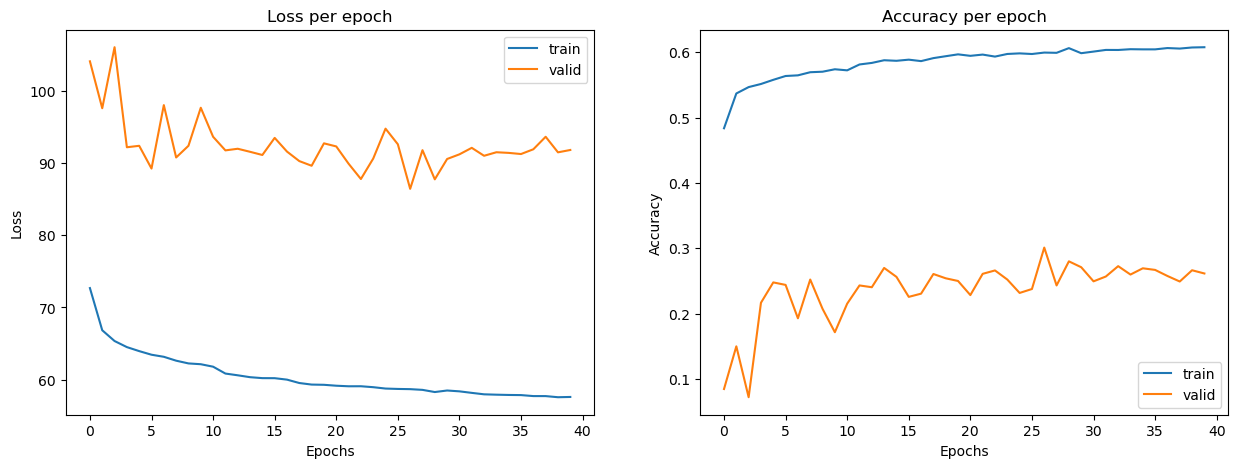

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 1s 272us/step
              precision    recall  f1-score   support

           0       0.69      0.82      0.75     46137
           1       0.13      0.61      0.22      3050
           2       0.32      0.50      0.39     17500
           3       0.74      0.26      0.38     45097

    accuracy                           0.53    111784
   macro avg       0.47      0.55      0.43    111784
weighted avg       0.64      0.53      0.53    111784
 




Classe prédite      0     1      2      3
Classe réelle                            
0               37643  2418   3786   2290
1                 199  1863    877    111
2                1858  5258   8737   1647
3               14576  4647  14319  11555



 Accuracy :  53.0


In [23]:
model6 = Sequential()
model6.add( Dense(units = 70, activation = "swish", input_shape = (X_train.shape[1],), kernel_initializer = kernel_initializer))
model6.add(Dense(units = 140, activation = "swish", kernel_initializer = kernel_initializer))
model6.add(Dropout(rate = 0.2))
model6.add( Dense(units = 70, activation = "swish", kernel_initializer = kernel_initializer))
model6.add(Dense(units = 35, activation = "swish", kernel_initializer = kernel_initializer))
model6.add(Dropout(rate = 0.2))
model6.add(Dense(units = 14, activation = "swish", kernel_initializer = kernel_initializer))
model6.add(Dense(units = 4, activation = 'softmax'))

model6.compile(loss = loss,
               optimizer = "adam",
               metrics = ['sparse_categorical_accuracy'])
    
history6 = model6.fit(X_train_ru, y_train_ru, epochs = 40, batch_size = 64, validation_split = 0.1, callbacks = [reduce_learning_rate])
    
plt.figure(figsize =(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history6.history['loss'], label = 'train')
plt.plot(history6.history['val_loss'], label = 'valid')
plt.xlabel("Epochs")
plt.ylabel('Loss')
plt.legend()
plt.title("Loss per epoch")

plt.subplot(1, 2, 2)
plt.plot(history6.history['sparse_categorical_accuracy'], label = 'train')
plt.plot(history6.history['val_sparse_categorical_accuracy'], label = 'valid')
plt.xlabel("Epochs")
plt.ylabel('Accuracy')
plt.legend()
plt.title("Accuracy per epoch")

plt.show()
test_pred = model6.predict(X_test)
test_pred_class = test_pred.argmax(axis=1)

# Affichage des résultats
print(classification_report(y_test, test_pred_class), '\n\n')

display(pd.crosstab(y_test, test_pred_class, rownames = ['Classe réelle'], colnames = ['Classe prédite']))
    
print('\n\n Accuracy : ', np.round(accuracy_score(y_test, test_pred_class), 2)*100)